# Sequential Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [3]:
import gym

# Create the Cart-Pole game environment
#env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
for _ in range(10):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

state, action, reward, done, info: [ 0.014771   -0.22946607  0.02836646  0.29549543] 0 1.0 False {}
state, action, reward, done, info: [ 0.01018168 -0.03475976  0.03427637  0.01189209] 1 1.0 False {}
state, action, reward, done, info: [ 0.00948648  0.15985428  0.03451421 -0.26978223] 1 1.0 False {}
state, action, reward, done, info: [ 0.01268357 -0.03574277  0.02911857  0.03358378] 0 1.0 False {}
state, action, reward, done, info: [ 0.01196871  0.15894977  0.02979024 -0.24977158] 1 1.0 False {}
state, action, reward, done, info: [ 0.01514771  0.35363391  0.02479481 -0.53291119] 1 1.0 False {}
state, action, reward, done, info: [ 0.02222039  0.54839853  0.01413659 -0.81767938] 1 1.0 False {}
state, action, reward, done, info: [ 0.03318836  0.74332414 -0.002217   -1.10588256] 1 1.0 False {}
state, action, reward, done, info: [ 0.04805484  0.93847517 -0.02433465 -1.39926019] 1 1.0 False {}
state, action, reward, done, info: [ 0.06682434  1.13389103 -0.05231985 -1.69945088] 1 1.0 False {}


To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
# print(rewards[-20:])
# print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
# print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
# print(np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
# print(np.max(np.array(rewards)), np.min(np.array(rewards)))
# print(np.max(np.array(states)), np.min(np.array(states)))

The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [6]:
def model_input(state_size, lstm_size, batch_size=1):
    actions = tf.placeholder(tf.int32, [None], name='actions')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    # RNN-GRU
    gru = tf.nn.rnn_cell.GRUCell(lstm_size)
    cell = tf.nn.rnn_cell.MultiRNNCell([gru], state_is_tuple=False)
    initial_state = cell.zero_state(batch_size, tf.float32)
    # Output
    return actions, states, targetQs, cell, initial_state

In [7]:
# RNN generator or sequence generator
def generator(states, initial_state, cell, lstm_size, num_classes, reuse=False): 
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        inputs = tf.layers.dense(inputs=states, units=lstm_size)
        print(states.shape, inputs.shape)
        
        # with tf.variable_scope('dynamic_rnn_', reuse=tf.AUTO_REUSE):
        # dynamic means adapt to the batch_size
        inputs_rnn = tf.reshape(inputs, [1, -1, lstm_size]) # NxH -> 1xNxH
        print(inputs_rnn.shape, initial_state.shape)
        outputs_rnn, final_state = tf.nn.dynamic_rnn(cell=cell, inputs=inputs_rnn, initial_state=initial_state)
        print(outputs_rnn.shape, final_state.shape)
        outputs = tf.reshape(outputs_rnn, [-1, lstm_size]) # 1xNxH -> NxH
        print(outputs.shape)

        # Last fully connected layer
        logits = tf.layers.dense(inputs=outputs, units=num_classes)
        print(logits.shape)
        #predictions = tf.nn.softmax(logits)
        
        # logits are the action logits
        return logits, final_state

In [8]:
def model_outputs(action_size, hidden_size, states, cell, initial_state):
    actions_logits, final_state = generator(states=states, cell=cell, initial_state=initial_state, 
                                            lstm_size=hidden_size, num_classes=action_size)
    return actions_logits, final_state

In [18]:
def model_loss(action_size, hidden_size, states, cell, initial_state, actions, targetQs):
    actions_logits, _ = generator(states=states, cell=cell, initial_state=initial_state, 
                                  lstm_size=hidden_size, num_classes=action_size, reuse=True)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs = tf.reduce_max(actions_logits*actions_labels, axis=1)
    #loss = tf.reduce_mean(tf.square(Qs - targetQs))
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs, 
                                                                  labels=tf.nn.sigmoid(targetQs)))
    return actions_logits, loss

In [19]:
def model_opt(loss, learning_rate):
    """
    Get optimization operations in order
    :param loss: Generator loss Tensor for action prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # # Optimize
    # with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
    # #opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    #grads, _ = tf.clip_by_global_norm(t_list=tf.gradients(loss, g_vars), clip_norm=5) # usually around 1-5
    grads = tf.gradients(loss, g_vars)
    opt = tf.train.AdamOptimizer(learning_rate).apply_gradients(grads_and_vars=zip(grads, g_vars))

    return opt

In [20]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.actions, self.states, self.targetQs, cell, self.initial_state = model_input(
            state_size=state_size, lstm_size=hidden_size)
        
        # Output of the Model: calculating the loss and forwad pass
        self.actions_logits, self.final_state = model_outputs(
            action_size=action_size, hidden_size=hidden_size, 
            states=self.states, cell=cell, initial_state=self.initial_state)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, 
            states=self.states, actions=self.actions, targetQs=self.targetQs, 
            cell=cell, initial_state=self.initial_state)

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [21]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
        self.states = deque(maxlen=max_size)

In [22]:
# episode_total_reward = deque(maxlen=10)

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [23]:
# print('state:', np.array(states).shape[1], 
#       'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

In [24]:
# Training parameters
batch_size = 32                # number of samples in the memory/ experience as mini-batch size
learning_rate = 0.001          # learning rate for adam

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
action_size = 2                # number of units for the output actions -- simulation

In [25]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=batch_size)

(?, 4) (?, 64)
(1, ?, 64) (1, 64)
(1, ?, 64) (1, 64)
(?, 64)
(?, 2)
(?, 4) (?, 64)
(1, ?, 64) (1, 64)
(1, ?, 64) (1, 64)
(?, 64)
(?, 2)


## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [26]:
state = env.reset()
for _ in range(batch_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    state = next_state
    if done is True:
        state = env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [27]:
memory.buffer[0]

[array([-0.04150246, -0.03170603, -0.01973341, -0.04574691]),
 0,
 array([-0.04213658, -0.22653954, -0.02064835,  0.2406452 ]),
 1.0,
 0.0]

In [28]:
# states, rewards, actions

In [29]:
# Now train with experiences
saver = tf.train.Saver() # save the trained model
rewards_list, loss_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    initial_state = sess.run(model.initial_state) # Qs or current batch or states[:-1]
    total_step = 0 # Explore or exploit parameter
    episode_loss = deque(maxlen=batch_size)
    episode_reward = deque(maxlen=batch_size)
    
    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0
        loss_batch = []
        state = env.reset()

        # Training steps/batches
        while True:
            action_logits, final_state = sess.run([model.actions_logits, model.final_state],
                                                  feed_dict = {model.states: state.reshape([1, -1]), 
                                                               model.initial_state: initial_state})
            
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.states.append([initial_state, final_state])
            total_reward += reward
            initial_state = final_state
            state = next_state

            # Training
            batch = memory.buffer
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            rnn_states = memory.states
            initial_states = np.array([each[0] for each in rnn_states])
            final_states = np.array([each[1] for each in rnn_states])
#             actions_logits = sess.run(model.actions_logits, 
#                                       feed_dict = {model.states: next_states, 
#                                                    model.initial_state: final_states[0].reshape([1, -1])})
#             nextQs = np.max(actions_logits, axis=1) * (1-dones)
#             targetQs = rewards + (0.99 * nextQs)
            actions_logits = sess.run(model.actions_logits,
                                      feed_dict = {model.states: states, 
                                                   model.initial_state: initial_states[0].reshape([1, -1])})
            targetQs = np.max(actions_logits, axis=1)
            loss, _ = sess.run([model.loss, model.opt], 
                               feed_dict = {model.states: states, 
                                            model.actions: actions,
                                            model.targetQs: targetQs,
                                            model.initial_state: initial_states[0].reshape([1, -1])})
            loss_batch.append(loss)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode: {}'.format(ep),
              'meanReward: {:.4f}'.format(np.mean(episode_reward)),
              'meanLoss: {:.4f}'.format(np.mean(loss_batch)),
              'ExploreP: {:.4f}'.format(explore_p))
        rewards_list.append([ep, np.mean(episode_reward)])
        loss_list.append([ep, np.mean(loss_batch)])
        if(np.mean(episode_reward) >= 500):
            break
    
    saver.save(sess, 'checkpoints/model2.ckpt')

Episode: 0 meanReward: 13.0000 meanLoss: 0.6620 ExploreP: 0.9987
Episode: 1 meanReward: 17.0000 meanLoss: 0.3657 ExploreP: 0.9966
Episode: 2 meanReward: 19.3333 meanLoss: 0.1642 ExploreP: 0.9943
Episode: 3 meanReward: 18.0000 meanLoss: 0.3719 ExploreP: 0.9929
Episode: 4 meanReward: 18.2000 meanLoss: 0.0453 ExploreP: 0.9910
Episode: 5 meanReward: 17.6667 meanLoss: 0.0044 ExploreP: 0.9896
Episode: 6 meanReward: 20.8571 meanLoss: 0.0039 ExploreP: 0.9857
Episode: 7 meanReward: 19.8750 meanLoss: 0.0038 ExploreP: 0.9844
Episode: 8 meanReward: 19.7778 meanLoss: 0.0038 ExploreP: 0.9825
Episode: 9 meanReward: 21.9000 meanLoss: 0.0036 ExploreP: 0.9786
Episode: 10 meanReward: 22.6364 meanLoss: 0.0033 ExploreP: 0.9757
Episode: 11 meanReward: 22.1667 meanLoss: 0.0033 ExploreP: 0.9740
Episode: 12 meanReward: 21.3077 meanLoss: 0.0032 ExploreP: 0.9730
Episode: 13 meanReward: 20.3571 meanLoss: 0.0032 ExploreP: 0.9722
Episode: 14 meanReward: 20.6000 meanLoss: 0.0031 ExploreP: 0.9699
Episode: 15 meanRewa

Episode: 124 meanReward: 24.3750 meanLoss: 0.0005 ExploreP: 0.7339
Episode: 125 meanReward: 24.0312 meanLoss: 0.0005 ExploreP: 0.7322
Episode: 126 meanReward: 23.6562 meanLoss: 0.0005 ExploreP: 0.7315
Episode: 127 meanReward: 23.9375 meanLoss: 0.0004 ExploreP: 0.7289
Episode: 128 meanReward: 23.1875 meanLoss: 0.0004 ExploreP: 0.7278
Episode: 129 meanReward: 23.2500 meanLoss: 0.0004 ExploreP: 0.7266
Episode: 130 meanReward: 23.0938 meanLoss: 0.0004 ExploreP: 0.7255
Episode: 131 meanReward: 22.6250 meanLoss: 0.0004 ExploreP: 0.7236
Episode: 132 meanReward: 23.1250 meanLoss: 0.0004 ExploreP: 0.7218
Episode: 133 meanReward: 23.1875 meanLoss: 0.0004 ExploreP: 0.7210
Episode: 134 meanReward: 23.3438 meanLoss: 0.0004 ExploreP: 0.7195
Episode: 135 meanReward: 23.3125 meanLoss: 0.0004 ExploreP: 0.7180
Episode: 136 meanReward: 22.8438 meanLoss: 0.0004 ExploreP: 0.7171
Episode: 137 meanReward: 22.7812 meanLoss: 0.0004 ExploreP: 0.7149
Episode: 138 meanReward: 22.9062 meanLoss: 0.0004 ExploreP: 0.

Episode: 247 meanReward: 23.7812 meanLoss: 0.0001 ExploreP: 0.5605
Episode: 248 meanReward: 22.8125 meanLoss: 0.0001 ExploreP: 0.5600
Episode: 249 meanReward: 22.5625 meanLoss: 0.0001 ExploreP: 0.5588
Episode: 250 meanReward: 23.5625 meanLoss: 0.0001 ExploreP: 0.5564
Episode: 251 meanReward: 23.3750 meanLoss: 0.0001 ExploreP: 0.5553
Episode: 252 meanReward: 23.3750 meanLoss: 0.0001 ExploreP: 0.5549
Episode: 253 meanReward: 23.8125 meanLoss: 0.0001 ExploreP: 0.5532
Episode: 254 meanReward: 23.9688 meanLoss: 0.0001 ExploreP: 0.5520
Episode: 255 meanReward: 23.9688 meanLoss: 0.0001 ExploreP: 0.5510
Episode: 256 meanReward: 24.0000 meanLoss: 0.0001 ExploreP: 0.5503
Episode: 257 meanReward: 24.5625 meanLoss: 0.0001 ExploreP: 0.5487
Episode: 258 meanReward: 24.6875 meanLoss: 0.0001 ExploreP: 0.5473
Episode: 259 meanReward: 24.7500 meanLoss: 0.0001 ExploreP: 0.5466
Episode: 260 meanReward: 23.7812 meanLoss: 0.0001 ExploreP: 0.5454
Episode: 261 meanReward: 23.8125 meanLoss: 0.0001 ExploreP: 0.

Episode: 371 meanReward: 18.3125 meanLoss: 0.0001 ExploreP: 0.4422
Episode: 372 meanReward: 18.1562 meanLoss: 0.0001 ExploreP: 0.4417
Episode: 373 meanReward: 18.5938 meanLoss: 0.0001 ExploreP: 0.4404
Episode: 374 meanReward: 18.6562 meanLoss: 0.0001 ExploreP: 0.4398
Episode: 375 meanReward: 18.2500 meanLoss: 0.0001 ExploreP: 0.4392
Episode: 376 meanReward: 18.5625 meanLoss: 0.0001 ExploreP: 0.4383
Episode: 377 meanReward: 18.7188 meanLoss: 0.0001 ExploreP: 0.4376
Episode: 378 meanReward: 18.2188 meanLoss: 0.0001 ExploreP: 0.4369
Episode: 379 meanReward: 17.4375 meanLoss: 0.0001 ExploreP: 0.4359
Episode: 380 meanReward: 17.3438 meanLoss: 0.0001 ExploreP: 0.4355
Episode: 381 meanReward: 17.2188 meanLoss: 0.0001 ExploreP: 0.4351
Episode: 382 meanReward: 18.2188 meanLoss: 0.0001 ExploreP: 0.4331
Episode: 383 meanReward: 18.5000 meanLoss: 0.0001 ExploreP: 0.4319
Episode: 384 meanReward: 18.2188 meanLoss: 0.0001 ExploreP: 0.4313
Episode: 385 meanReward: 18.0312 meanLoss: 0.0001 ExploreP: 0.

Episode: 494 meanReward: 20.6562 meanLoss: 0.0000 ExploreP: 0.3479
Episode: 495 meanReward: 20.7188 meanLoss: 0.0000 ExploreP: 0.3473
Episode: 496 meanReward: 21.8438 meanLoss: 0.0000 ExploreP: 0.3455
Episode: 497 meanReward: 22.0312 meanLoss: 0.0000 ExploreP: 0.3449
Episode: 498 meanReward: 21.5625 meanLoss: 0.0000 ExploreP: 0.3446
Episode: 499 meanReward: 22.7188 meanLoss: 0.0000 ExploreP: 0.3430
Episode: 500 meanReward: 22.7188 meanLoss: 0.0000 ExploreP: 0.3424
Episode: 501 meanReward: 23.0312 meanLoss: 0.0000 ExploreP: 0.3415
Episode: 502 meanReward: 23.0312 meanLoss: 0.0000 ExploreP: 0.3411
Episode: 503 meanReward: 23.0000 meanLoss: 0.0000 ExploreP: 0.3401
Episode: 504 meanReward: 23.0625 meanLoss: 0.0000 ExploreP: 0.3397
Episode: 505 meanReward: 21.6875 meanLoss: 0.0000 ExploreP: 0.3394
Episode: 506 meanReward: 21.3438 meanLoss: 0.0000 ExploreP: 0.3390
Episode: 507 meanReward: 21.5938 meanLoss: 0.0000 ExploreP: 0.3384
Episode: 508 meanReward: 21.5000 meanLoss: 0.0000 ExploreP: 0.

Episode: 618 meanReward: 13.9688 meanLoss: 0.0000 ExploreP: 0.2841
Episode: 619 meanReward: 14.0312 meanLoss: 0.0000 ExploreP: 0.2838
Episode: 620 meanReward: 13.5000 meanLoss: 0.0000 ExploreP: 0.2835
Episode: 621 meanReward: 14.0000 meanLoss: 0.0000 ExploreP: 0.2828
Episode: 622 meanReward: 14.0000 meanLoss: 0.0000 ExploreP: 0.2825
Episode: 623 meanReward: 14.0000 meanLoss: 0.0000 ExploreP: 0.2822
Episode: 624 meanReward: 13.9062 meanLoss: 0.0000 ExploreP: 0.2820
Episode: 625 meanReward: 14.0312 meanLoss: 0.0000 ExploreP: 0.2816
Episode: 626 meanReward: 14.0625 meanLoss: 0.0000 ExploreP: 0.2812
Episode: 627 meanReward: 14.2500 meanLoss: 0.0000 ExploreP: 0.2808
Episode: 628 meanReward: 14.3125 meanLoss: 0.0000 ExploreP: 0.2805
Episode: 629 meanReward: 14.2812 meanLoss: 0.0000 ExploreP: 0.2802
Episode: 630 meanReward: 13.2500 meanLoss: 0.0000 ExploreP: 0.2800
Episode: 631 meanReward: 13.2188 meanLoss: 0.0000 ExploreP: 0.2797
Episode: 632 meanReward: 11.9062 meanLoss: 0.0000 ExploreP: 0.

Episode: 742 meanReward: 11.0625 meanLoss: 0.0000 ExploreP: 0.2475
Episode: 743 meanReward: 11.0938 meanLoss: 0.0000 ExploreP: 0.2472
Episode: 744 meanReward: 11.0625 meanLoss: 0.0000 ExploreP: 0.2470
Episode: 745 meanReward: 11.0312 meanLoss: 0.0000 ExploreP: 0.2467
Episode: 746 meanReward: 11.0312 meanLoss: 0.0000 ExploreP: 0.2465
Episode: 747 meanReward: 11.0625 meanLoss: 0.0000 ExploreP: 0.2462
Episode: 748 meanReward: 11.0312 meanLoss: 0.0000 ExploreP: 0.2460
Episode: 749 meanReward: 10.9062 meanLoss: 0.0000 ExploreP: 0.2458
Episode: 750 meanReward: 10.9688 meanLoss: 0.0000 ExploreP: 0.2455
Episode: 751 meanReward: 10.9062 meanLoss: 0.0000 ExploreP: 0.2453
Episode: 752 meanReward: 11.2188 meanLoss: 0.0000 ExploreP: 0.2449
Episode: 753 meanReward: 11.0312 meanLoss: 0.0000 ExploreP: 0.2446
Episode: 754 meanReward: 11.0312 meanLoss: 0.0000 ExploreP: 0.2444
Episode: 755 meanReward: 11.0625 meanLoss: 0.0000 ExploreP: 0.2442
Episode: 756 meanReward: 11.0938 meanLoss: 0.0000 ExploreP: 0.

Episode: 865 meanReward: 16.5625 meanLoss: 0.0000 ExploreP: 0.2108
Episode: 866 meanReward: 16.4375 meanLoss: 0.0000 ExploreP: 0.2106
Episode: 867 meanReward: 16.4062 meanLoss: 0.0000 ExploreP: 0.2104
Episode: 868 meanReward: 16.4062 meanLoss: 0.0000 ExploreP: 0.2102
Episode: 869 meanReward: 15.4688 meanLoss: 0.0000 ExploreP: 0.2100
Episode: 870 meanReward: 15.5312 meanLoss: 0.0000 ExploreP: 0.2098
Episode: 871 meanReward: 15.6250 meanLoss: 0.0000 ExploreP: 0.2096
Episode: 872 meanReward: 14.6250 meanLoss: 0.0000 ExploreP: 0.2093
Episode: 873 meanReward: 14.7500 meanLoss: 0.0000 ExploreP: 0.2090
Episode: 874 meanReward: 14.6250 meanLoss: 0.0000 ExploreP: 0.2084
Episode: 875 meanReward: 14.6875 meanLoss: 0.0000 ExploreP: 0.2082
Episode: 876 meanReward: 14.6250 meanLoss: 0.0000 ExploreP: 0.2080
Episode: 877 meanReward: 14.5312 meanLoss: 0.0000 ExploreP: 0.2078
Episode: 878 meanReward: 15.0000 meanLoss: 0.0000 ExploreP: 0.2073
Episode: 879 meanReward: 14.8750 meanLoss: 0.0000 ExploreP: 0.

Episode: 988 meanReward: 13.4688 meanLoss: 0.0000 ExploreP: 0.1824
Episode: 989 meanReward: 13.5625 meanLoss: 0.0000 ExploreP: 0.1822
Episode: 990 meanReward: 13.9688 meanLoss: 0.0000 ExploreP: 0.1818
Episode: 991 meanReward: 14.0000 meanLoss: 0.0000 ExploreP: 0.1816
Episode: 992 meanReward: 14.2188 meanLoss: 0.0000 ExploreP: 0.1813
Episode: 993 meanReward: 14.2188 meanLoss: 0.0000 ExploreP: 0.1811
Episode: 994 meanReward: 14.2500 meanLoss: 0.0000 ExploreP: 0.1809
Episode: 995 meanReward: 14.2812 meanLoss: 0.0000 ExploreP: 0.1807
Episode: 996 meanReward: 14.2500 meanLoss: 0.0000 ExploreP: 0.1806
Episode: 997 meanReward: 14.8438 meanLoss: 0.0000 ExploreP: 0.1801
Episode: 998 meanReward: 14.8438 meanLoss: 0.0000 ExploreP: 0.1799
Episode: 999 meanReward: 14.7500 meanLoss: 0.0000 ExploreP: 0.1795
Episode: 1000 meanReward: 14.4375 meanLoss: 0.0000 ExploreP: 0.1793
Episode: 1001 meanReward: 14.3125 meanLoss: 0.0000 ExploreP: 0.1791
Episode: 1002 meanReward: 14.4375 meanLoss: 0.0000 ExploreP:

Episode: 1109 meanReward: 14.8125 meanLoss: 0.0000 ExploreP: 0.1536
Episode: 1110 meanReward: 14.7188 meanLoss: 0.0000 ExploreP: 0.1533
Episode: 1111 meanReward: 14.7188 meanLoss: 0.0000 ExploreP: 0.1532
Episode: 1112 meanReward: 14.6250 meanLoss: 0.0000 ExploreP: 0.1530
Episode: 1113 meanReward: 14.1250 meanLoss: 0.0000 ExploreP: 0.1528
Episode: 1114 meanReward: 13.8438 meanLoss: 0.0000 ExploreP: 0.1526
Episode: 1115 meanReward: 13.8438 meanLoss: 0.0000 ExploreP: 0.1525
Episode: 1116 meanReward: 13.3750 meanLoss: 0.0000 ExploreP: 0.1524
Episode: 1117 meanReward: 13.9688 meanLoss: 0.0000 ExploreP: 0.1520
Episode: 1118 meanReward: 13.8125 meanLoss: 0.0000 ExploreP: 0.1517
Episode: 1119 meanReward: 13.7500 meanLoss: 0.0000 ExploreP: 0.1515
Episode: 1120 meanReward: 13.9375 meanLoss: 0.0000 ExploreP: 0.1512
Episode: 1121 meanReward: 14.3125 meanLoss: 0.0000 ExploreP: 0.1508
Episode: 1122 meanReward: 14.7812 meanLoss: 0.0000 ExploreP: 0.1501
Episode: 1123 meanReward: 14.8750 meanLoss: 0.00

Episode: 1230 meanReward: 20.8750 meanLoss: 0.0000 ExploreP: 0.1242
Episode: 1231 meanReward: 20.1875 meanLoss: 0.0000 ExploreP: 0.1241
Episode: 1232 meanReward: 20.5938 meanLoss: 0.0000 ExploreP: 0.1239
Episode: 1233 meanReward: 20.5312 meanLoss: 0.0000 ExploreP: 0.1238
Episode: 1234 meanReward: 20.4688 meanLoss: 0.0000 ExploreP: 0.1237
Episode: 1235 meanReward: 20.7500 meanLoss: 0.0000 ExploreP: 0.1233
Episode: 1236 meanReward: 20.7500 meanLoss: 0.0000 ExploreP: 0.1232
Episode: 1237 meanReward: 20.6250 meanLoss: 0.0000 ExploreP: 0.1231
Episode: 1238 meanReward: 21.8125 meanLoss: 0.0000 ExploreP: 0.1223
Episode: 1239 meanReward: 21.6875 meanLoss: 0.0000 ExploreP: 0.1222
Episode: 1240 meanReward: 21.8125 meanLoss: 0.0000 ExploreP: 0.1221
Episode: 1241 meanReward: 23.2812 meanLoss: 0.0000 ExploreP: 0.1214
Episode: 1242 meanReward: 23.3125 meanLoss: 0.0000 ExploreP: 0.1213
Episode: 1243 meanReward: 24.5312 meanLoss: 0.0000 ExploreP: 0.1208
Episode: 1244 meanReward: 24.4688 meanLoss: 0.00

Episode: 1352 meanReward: 18.0625 meanLoss: 0.0000 ExploreP: 0.0999
Episode: 1353 meanReward: 18.0625 meanLoss: 0.0000 ExploreP: 0.0998
Episode: 1354 meanReward: 18.5938 meanLoss: 0.0000 ExploreP: 0.0996
Episode: 1355 meanReward: 18.6875 meanLoss: 0.0000 ExploreP: 0.0995
Episode: 1356 meanReward: 18.7500 meanLoss: 0.0000 ExploreP: 0.0994
Episode: 1357 meanReward: 18.5625 meanLoss: 0.0000 ExploreP: 0.0993
Episode: 1358 meanReward: 19.2500 meanLoss: 0.0000 ExploreP: 0.0990
Episode: 1359 meanReward: 18.6875 meanLoss: 0.0000 ExploreP: 0.0989
Episode: 1360 meanReward: 18.7188 meanLoss: 0.0000 ExploreP: 0.0988
Episode: 1361 meanReward: 19.5625 meanLoss: 0.0000 ExploreP: 0.0985
Episode: 1362 meanReward: 18.9375 meanLoss: 0.0000 ExploreP: 0.0984
Episode: 1363 meanReward: 18.9375 meanLoss: 0.0000 ExploreP: 0.0983
Episode: 1364 meanReward: 18.9375 meanLoss: 0.0000 ExploreP: 0.0982
Episode: 1365 meanReward: 19.6562 meanLoss: 0.0000 ExploreP: 0.0979
Episode: 1366 meanReward: 18.8750 meanLoss: 0.00

Episode: 1473 meanReward: 29.1875 meanLoss: 0.0000 ExploreP: 0.0785
Episode: 1474 meanReward: 29.1562 meanLoss: 0.0000 ExploreP: 0.0784
Episode: 1475 meanReward: 30.2188 meanLoss: 0.0000 ExploreP: 0.0781
Episode: 1476 meanReward: 32.1250 meanLoss: 0.0000 ExploreP: 0.0776
Episode: 1477 meanReward: 31.4375 meanLoss: 0.0000 ExploreP: 0.0776
Episode: 1478 meanReward: 31.5000 meanLoss: 0.0000 ExploreP: 0.0775
Episode: 1479 meanReward: 33.6875 meanLoss: 0.0000 ExploreP: 0.0770
Episode: 1480 meanReward: 33.0625 meanLoss: 0.0000 ExploreP: 0.0769
Episode: 1481 meanReward: 33.0938 meanLoss: 0.0000 ExploreP: 0.0768
Episode: 1482 meanReward: 33.6250 meanLoss: 0.0000 ExploreP: 0.0766
Episode: 1483 meanReward: 33.6250 meanLoss: 0.0000 ExploreP: 0.0766
Episode: 1484 meanReward: 32.8438 meanLoss: 0.0000 ExploreP: 0.0765
Episode: 1485 meanReward: 32.7812 meanLoss: 0.0000 ExploreP: 0.0764
Episode: 1486 meanReward: 33.1562 meanLoss: 0.0000 ExploreP: 0.0762
Episode: 1487 meanReward: 32.0625 meanLoss: 0.00

Episode: 1595 meanReward: 21.2188 meanLoss: 0.0000 ExploreP: 0.0647
Episode: 1596 meanReward: 21.8438 meanLoss: 0.0000 ExploreP: 0.0645
Episode: 1597 meanReward: 21.3438 meanLoss: 0.0000 ExploreP: 0.0644
Episode: 1598 meanReward: 21.3438 meanLoss: 0.0000 ExploreP: 0.0644
Episode: 1599 meanReward: 21.0625 meanLoss: 0.0000 ExploreP: 0.0642
Episode: 1600 meanReward: 21.0312 meanLoss: 0.0000 ExploreP: 0.0642
Episode: 1601 meanReward: 22.0625 meanLoss: 0.0000 ExploreP: 0.0639
Episode: 1602 meanReward: 21.4375 meanLoss: 0.0000 ExploreP: 0.0639
Episode: 1603 meanReward: 21.8125 meanLoss: 0.0000 ExploreP: 0.0637
Episode: 1604 meanReward: 25.1250 meanLoss: 0.0000 ExploreP: 0.0631
Episode: 1605 meanReward: 24.6875 meanLoss: 0.0000 ExploreP: 0.0631
Episode: 1606 meanReward: 25.3750 meanLoss: 0.0000 ExploreP: 0.0627
Episode: 1607 meanReward: 25.4688 meanLoss: 0.0000 ExploreP: 0.0626
Episode: 1608 meanReward: 26.5000 meanLoss: 0.0000 ExploreP: 0.0624
Episode: 1609 meanReward: 24.7812 meanLoss: 0.00

Episode: 1717 meanReward: 14.3438 meanLoss: 0.0000 ExploreP: 0.0532
Episode: 1718 meanReward: 13.5625 meanLoss: 0.0000 ExploreP: 0.0531
Episode: 1719 meanReward: 13.5312 meanLoss: 0.0000 ExploreP: 0.0531
Episode: 1720 meanReward: 13.5625 meanLoss: 0.0000 ExploreP: 0.0531
Episode: 1721 meanReward: 13.5625 meanLoss: 0.0000 ExploreP: 0.0530
Episode: 1722 meanReward: 13.5625 meanLoss: 0.0000 ExploreP: 0.0530
Episode: 1723 meanReward: 14.3125 meanLoss: 0.0000 ExploreP: 0.0528
Episode: 1724 meanReward: 14.3125 meanLoss: 0.0000 ExploreP: 0.0528
Episode: 1725 meanReward: 14.3125 meanLoss: 0.0000 ExploreP: 0.0527
Episode: 1726 meanReward: 14.6250 meanLoss: 0.0000 ExploreP: 0.0527
Episode: 1727 meanReward: 14.6562 meanLoss: 0.0000 ExploreP: 0.0526
Episode: 1728 meanReward: 14.7188 meanLoss: 0.0000 ExploreP: 0.0526
Episode: 1729 meanReward: 14.6875 meanLoss: 0.0000 ExploreP: 0.0525
Episode: 1730 meanReward: 13.6875 meanLoss: 0.0000 ExploreP: 0.0525
Episode: 1731 meanReward: 13.6250 meanLoss: 0.00

Episode: 1838 meanReward: 15.1250 meanLoss: 0.0000 ExploreP: 0.0458
Episode: 1839 meanReward: 15.1562 meanLoss: 0.0000 ExploreP: 0.0457
Episode: 1840 meanReward: 16.0625 meanLoss: 0.0000 ExploreP: 0.0456
Episode: 1841 meanReward: 16.0625 meanLoss: 0.0000 ExploreP: 0.0456
Episode: 1842 meanReward: 16.0938 meanLoss: 0.0000 ExploreP: 0.0455
Episode: 1843 meanReward: 16.0312 meanLoss: 0.0000 ExploreP: 0.0455
Episode: 1844 meanReward: 15.3750 meanLoss: 0.0000 ExploreP: 0.0455
Episode: 1845 meanReward: 15.3438 meanLoss: 0.0000 ExploreP: 0.0454
Episode: 1846 meanReward: 15.3438 meanLoss: 0.0000 ExploreP: 0.0454
Episode: 1847 meanReward: 15.3750 meanLoss: 0.0000 ExploreP: 0.0454
Episode: 1848 meanReward: 14.6875 meanLoss: 0.0000 ExploreP: 0.0453
Episode: 1849 meanReward: 14.7188 meanLoss: 0.0000 ExploreP: 0.0453
Episode: 1850 meanReward: 15.2812 meanLoss: 0.0000 ExploreP: 0.0452
Episode: 1851 meanReward: 14.2188 meanLoss: 0.0000 ExploreP: 0.0452
Episode: 1852 meanReward: 14.2500 meanLoss: 0.00

Episode: 1959 meanReward: 15.6250 meanLoss: 0.0000 ExploreP: 0.0393
Episode: 1960 meanReward: 16.0938 meanLoss: 0.0000 ExploreP: 0.0393
Episode: 1961 meanReward: 16.3750 meanLoss: 0.0000 ExploreP: 0.0392
Episode: 1962 meanReward: 16.3438 meanLoss: 0.0000 ExploreP: 0.0392
Episode: 1963 meanReward: 17.5625 meanLoss: 0.0000 ExploreP: 0.0390
Episode: 1964 meanReward: 17.5625 meanLoss: 0.0000 ExploreP: 0.0390
Episode: 1965 meanReward: 17.5312 meanLoss: 0.0000 ExploreP: 0.0390
Episode: 1966 meanReward: 18.2812 meanLoss: 0.0000 ExploreP: 0.0389
Episode: 1967 meanReward: 18.2500 meanLoss: 0.0000 ExploreP: 0.0388
Episode: 1968 meanReward: 18.2500 meanLoss: 0.0000 ExploreP: 0.0388
Episode: 1969 meanReward: 18.2188 meanLoss: 0.0000 ExploreP: 0.0387
Episode: 1970 meanReward: 18.2188 meanLoss: 0.0000 ExploreP: 0.0387
Episode: 1971 meanReward: 18.2188 meanLoss: 0.0000 ExploreP: 0.0387
Episode: 1972 meanReward: 19.5938 meanLoss: 0.0000 ExploreP: 0.0385
Episode: 1973 meanReward: 18.7812 meanLoss: 0.00

Episode: 2081 meanReward: 13.8125 meanLoss: 0.0000 ExploreP: 0.0344
Episode: 2082 meanReward: 13.8125 meanLoss: 0.0000 ExploreP: 0.0344
Episode: 2083 meanReward: 12.8438 meanLoss: 0.0000 ExploreP: 0.0344
Episode: 2084 meanReward: 12.8750 meanLoss: 0.0000 ExploreP: 0.0344
Episode: 2085 meanReward: 12.9062 meanLoss: 0.0000 ExploreP: 0.0343
Episode: 2086 meanReward: 11.8750 meanLoss: 0.0000 ExploreP: 0.0343
Episode: 2087 meanReward: 11.9062 meanLoss: 0.0000 ExploreP: 0.0343
Episode: 2088 meanReward: 12.7812 meanLoss: 0.0000 ExploreP: 0.0342
Episode: 2089 meanReward: 12.8125 meanLoss: 0.0000 ExploreP: 0.0342
Episode: 2090 meanReward: 12.8750 meanLoss: 0.0000 ExploreP: 0.0342
Episode: 2091 meanReward: 13.8750 meanLoss: 0.0000 ExploreP: 0.0341
Episode: 2092 meanReward: 13.8750 meanLoss: 0.0000 ExploreP: 0.0340
Episode: 2093 meanReward: 13.8750 meanLoss: 0.0000 ExploreP: 0.0340
Episode: 2094 meanReward: 13.9062 meanLoss: 0.0000 ExploreP: 0.0340
Episode: 2095 meanReward: 15.3125 meanLoss: 0.00

Episode: 2202 meanReward: 11.5938 meanLoss: 0.0000 ExploreP: 0.0309
Episode: 2203 meanReward: 11.5312 meanLoss: 0.0000 ExploreP: 0.0309
Episode: 2204 meanReward: 11.5312 meanLoss: 0.0000 ExploreP: 0.0309
Episode: 2205 meanReward: 11.5312 meanLoss: 0.0000 ExploreP: 0.0309
Episode: 2206 meanReward: 11.4688 meanLoss: 0.0000 ExploreP: 0.0309
Episode: 2207 meanReward: 11.4688 meanLoss: 0.0000 ExploreP: 0.0309
Episode: 2208 meanReward: 11.5312 meanLoss: 0.0000 ExploreP: 0.0308
Episode: 2209 meanReward: 11.5000 meanLoss: 0.0000 ExploreP: 0.0308
Episode: 2210 meanReward: 11.5312 meanLoss: 0.0000 ExploreP: 0.0308
Episode: 2211 meanReward: 11.5000 meanLoss: 0.0000 ExploreP: 0.0308
Episode: 2212 meanReward: 11.5625 meanLoss: 0.0000 ExploreP: 0.0307
Episode: 2213 meanReward: 11.5625 meanLoss: 0.0000 ExploreP: 0.0307
Episode: 2214 meanReward: 12.6875 meanLoss: 0.0000 ExploreP: 0.0306
Episode: 2215 meanReward: 12.6562 meanLoss: 0.0000 ExploreP: 0.0306
Episode: 2216 meanReward: 11.5938 meanLoss: 0.00

Episode: 2323 meanReward: 17.8750 meanLoss: 0.0000 ExploreP: 0.0274
Episode: 2324 meanReward: 17.4062 meanLoss: 0.0000 ExploreP: 0.0274
Episode: 2325 meanReward: 17.4375 meanLoss: 0.0000 ExploreP: 0.0274
Episode: 2326 meanReward: 16.2188 meanLoss: 0.0000 ExploreP: 0.0274
Episode: 2327 meanReward: 14.5312 meanLoss: 0.0000 ExploreP: 0.0274
Episode: 2328 meanReward: 14.4375 meanLoss: 0.0000 ExploreP: 0.0274
Episode: 2329 meanReward: 14.3750 meanLoss: 0.0000 ExploreP: 0.0273
Episode: 2330 meanReward: 14.3750 meanLoss: 0.0000 ExploreP: 0.0273
Episode: 2331 meanReward: 14.3125 meanLoss: 0.0000 ExploreP: 0.0273
Episode: 2332 meanReward: 14.2188 meanLoss: 0.0000 ExploreP: 0.0273
Episode: 2333 meanReward: 12.9375 meanLoss: 0.0000 ExploreP: 0.0273
Episode: 2334 meanReward: 13.0000 meanLoss: 0.0000 ExploreP: 0.0273
Episode: 2335 meanReward: 12.9062 meanLoss: 0.0000 ExploreP: 0.0273
Episode: 2336 meanReward: 12.9688 meanLoss: 0.0000 ExploreP: 0.0272
Episode: 2337 meanReward: 12.8750 meanLoss: 0.00

Episode: 2444 meanReward: 15.3750 meanLoss: 0.0000 ExploreP: 0.0250
Episode: 2445 meanReward: 15.2812 meanLoss: 0.0000 ExploreP: 0.0249
Episode: 2446 meanReward: 15.3125 meanLoss: 0.0000 ExploreP: 0.0249
Episode: 2447 meanReward: 15.3750 meanLoss: 0.0000 ExploreP: 0.0249
Episode: 2448 meanReward: 15.3750 meanLoss: 0.0000 ExploreP: 0.0249
Episode: 2449 meanReward: 14.5312 meanLoss: 0.0000 ExploreP: 0.0249
Episode: 2450 meanReward: 15.5625 meanLoss: 0.0000 ExploreP: 0.0248
Episode: 2451 meanReward: 15.5000 meanLoss: 0.0000 ExploreP: 0.0248
Episode: 2452 meanReward: 15.5312 meanLoss: 0.0000 ExploreP: 0.0248
Episode: 2453 meanReward: 15.0000 meanLoss: 0.0000 ExploreP: 0.0248
Episode: 2454 meanReward: 14.3750 meanLoss: 0.0000 ExploreP: 0.0248
Episode: 2455 meanReward: 15.4375 meanLoss: 0.0000 ExploreP: 0.0247
Episode: 2456 meanReward: 14.5938 meanLoss: 0.0000 ExploreP: 0.0247
Episode: 2457 meanReward: 14.5938 meanLoss: 0.0000 ExploreP: 0.0247
Episode: 2458 meanReward: 14.5312 meanLoss: 0.00

Episode: 2566 meanReward: 14.9375 meanLoss: 0.0000 ExploreP: 0.0228
Episode: 2567 meanReward: 14.9375 meanLoss: 0.0000 ExploreP: 0.0228
Episode: 2568 meanReward: 15.3750 meanLoss: 0.0000 ExploreP: 0.0228
Episode: 2569 meanReward: 15.8125 meanLoss: 0.0000 ExploreP: 0.0227
Episode: 2570 meanReward: 16.2812 meanLoss: 0.0000 ExploreP: 0.0227
Episode: 2571 meanReward: 16.2188 meanLoss: 0.0000 ExploreP: 0.0227
Episode: 2572 meanReward: 16.1875 meanLoss: 0.0000 ExploreP: 0.0227
Episode: 2573 meanReward: 17.3750 meanLoss: 0.0000 ExploreP: 0.0226
Episode: 2574 meanReward: 17.4062 meanLoss: 0.0000 ExploreP: 0.0226
Episode: 2575 meanReward: 16.8750 meanLoss: 0.0000 ExploreP: 0.0226
Episode: 2576 meanReward: 16.8750 meanLoss: 0.0000 ExploreP: 0.0226
Episode: 2577 meanReward: 16.8438 meanLoss: 0.0000 ExploreP: 0.0226
Episode: 2578 meanReward: 16.8125 meanLoss: 0.0000 ExploreP: 0.0226
Episode: 2579 meanReward: 16.8125 meanLoss: 0.0000 ExploreP: 0.0225
Episode: 2580 meanReward: 16.7500 meanLoss: 0.00

Episode: 2688 meanReward: 11.6250 meanLoss: 0.0000 ExploreP: 0.0210
Episode: 2689 meanReward: 11.5938 meanLoss: 0.0000 ExploreP: 0.0210
Episode: 2690 meanReward: 11.5938 meanLoss: 0.0000 ExploreP: 0.0210
Episode: 2691 meanReward: 11.5938 meanLoss: 0.0000 ExploreP: 0.0210
Episode: 2692 meanReward: 11.5938 meanLoss: 0.0000 ExploreP: 0.0210
Episode: 2693 meanReward: 11.5938 meanLoss: 0.0000 ExploreP: 0.0210
Episode: 2694 meanReward: 11.6250 meanLoss: 0.0000 ExploreP: 0.0210
Episode: 2695 meanReward: 11.6562 meanLoss: 0.0000 ExploreP: 0.0210
Episode: 2696 meanReward: 13.0625 meanLoss: 0.0000 ExploreP: 0.0209
Episode: 2697 meanReward: 13.0625 meanLoss: 0.0000 ExploreP: 0.0209
Episode: 2698 meanReward: 13.1250 meanLoss: 0.0000 ExploreP: 0.0209
Episode: 2699 meanReward: 13.1562 meanLoss: 0.0000 ExploreP: 0.0209
Episode: 2700 meanReward: 14.1875 meanLoss: 0.0000 ExploreP: 0.0208
Episode: 2701 meanReward: 14.1562 meanLoss: 0.0000 ExploreP: 0.0208
Episode: 2702 meanReward: 14.1562 meanLoss: 0.00

Episode: 2809 meanReward: 17.6562 meanLoss: 0.0000 ExploreP: 0.0191
Episode: 2810 meanReward: 17.6562 meanLoss: 0.0000 ExploreP: 0.0190
Episode: 2811 meanReward: 17.6250 meanLoss: 0.0000 ExploreP: 0.0190
Episode: 2812 meanReward: 17.5625 meanLoss: 0.0000 ExploreP: 0.0190
Episode: 2813 meanReward: 17.5938 meanLoss: 0.0000 ExploreP: 0.0190
Episode: 2814 meanReward: 17.0000 meanLoss: 0.0000 ExploreP: 0.0190
Episode: 2815 meanReward: 17.0312 meanLoss: 0.0000 ExploreP: 0.0190
Episode: 2816 meanReward: 17.0312 meanLoss: 0.0000 ExploreP: 0.0190
Episode: 2817 meanReward: 17.0938 meanLoss: 0.0000 ExploreP: 0.0190
Episode: 2818 meanReward: 17.1250 meanLoss: 0.0000 ExploreP: 0.0190
Episode: 2819 meanReward: 17.0938 meanLoss: 0.0000 ExploreP: 0.0190
Episode: 2820 meanReward: 17.1250 meanLoss: 0.0000 ExploreP: 0.0190
Episode: 2821 meanReward: 17.1250 meanLoss: 0.0000 ExploreP: 0.0189
Episode: 2822 meanReward: 17.0625 meanLoss: 0.0000 ExploreP: 0.0189
Episode: 2823 meanReward: 17.0312 meanLoss: 0.00

Episode: 2930 meanReward: 10.4688 meanLoss: 0.0000 ExploreP: 0.0179
Episode: 2931 meanReward: 10.5000 meanLoss: 0.0000 ExploreP: 0.0179
Episode: 2932 meanReward: 10.5312 meanLoss: 0.0000 ExploreP: 0.0179
Episode: 2933 meanReward: 11.9375 meanLoss: 0.0000 ExploreP: 0.0178
Episode: 2934 meanReward: 11.9688 meanLoss: 0.0000 ExploreP: 0.0178
Episode: 2935 meanReward: 11.9375 meanLoss: 0.0000 ExploreP: 0.0178
Episode: 2936 meanReward: 11.9375 meanLoss: 0.0000 ExploreP: 0.0178
Episode: 2937 meanReward: 12.9375 meanLoss: 0.0000 ExploreP: 0.0178
Episode: 2938 meanReward: 11.7812 meanLoss: 0.0000 ExploreP: 0.0178
Episode: 2939 meanReward: 12.2188 meanLoss: 0.0000 ExploreP: 0.0177
Episode: 2940 meanReward: 12.2500 meanLoss: 0.0000 ExploreP: 0.0177
Episode: 2941 meanReward: 12.2500 meanLoss: 0.0000 ExploreP: 0.0177
Episode: 2942 meanReward: 12.2500 meanLoss: 0.0000 ExploreP: 0.0177
Episode: 2943 meanReward: 12.2812 meanLoss: 0.0000 ExploreP: 0.0177
Episode: 2944 meanReward: 12.2812 meanLoss: 0.00

Episode: 3052 meanReward: 13.4062 meanLoss: 0.0000 ExploreP: 0.0168
Episode: 3053 meanReward: 13.8438 meanLoss: 0.0000 ExploreP: 0.0168
Episode: 3054 meanReward: 13.9062 meanLoss: 0.0000 ExploreP: 0.0168
Episode: 3055 meanReward: 13.9375 meanLoss: 0.0000 ExploreP: 0.0167
Episode: 3056 meanReward: 13.8125 meanLoss: 0.0000 ExploreP: 0.0167
Episode: 3057 meanReward: 13.8125 meanLoss: 0.0000 ExploreP: 0.0167
Episode: 3058 meanReward: 13.2500 meanLoss: 0.0000 ExploreP: 0.0167
Episode: 3059 meanReward: 12.7500 meanLoss: 0.0000 ExploreP: 0.0167
Episode: 3060 meanReward: 13.7812 meanLoss: 0.0000 ExploreP: 0.0167
Episode: 3061 meanReward: 13.8438 meanLoss: 0.0000 ExploreP: 0.0167
Episode: 3062 meanReward: 13.7812 meanLoss: 0.0000 ExploreP: 0.0167
Episode: 3063 meanReward: 13.8125 meanLoss: 0.0000 ExploreP: 0.0167
Episode: 3064 meanReward: 13.7812 meanLoss: 0.0000 ExploreP: 0.0167
Episode: 3065 meanReward: 13.7812 meanLoss: 0.0000 ExploreP: 0.0167
Episode: 3066 meanReward: 14.3125 meanLoss: 0.00

Episode: 3174 meanReward: 10.6250 meanLoss: 0.0000 ExploreP: 0.0158
Episode: 3175 meanReward: 10.5625 meanLoss: 0.0000 ExploreP: 0.0158
Episode: 3176 meanReward: 10.5938 meanLoss: 0.0000 ExploreP: 0.0158
Episode: 3177 meanReward: 10.6250 meanLoss: 0.0000 ExploreP: 0.0158
Episode: 3178 meanReward: 10.6250 meanLoss: 0.0000 ExploreP: 0.0158
Episode: 3179 meanReward: 10.6562 meanLoss: 0.0000 ExploreP: 0.0158
Episode: 3180 meanReward: 10.5938 meanLoss: 0.0000 ExploreP: 0.0158
Episode: 3181 meanReward: 10.5938 meanLoss: 0.0000 ExploreP: 0.0158
Episode: 3182 meanReward: 10.5625 meanLoss: 0.0000 ExploreP: 0.0158
Episode: 3183 meanReward: 10.5000 meanLoss: 0.0000 ExploreP: 0.0158
Episode: 3184 meanReward: 10.5938 meanLoss: 0.0000 ExploreP: 0.0158
Episode: 3185 meanReward: 10.6250 meanLoss: 0.0000 ExploreP: 0.0158
Episode: 3186 meanReward: 9.3750 meanLoss: 0.0000 ExploreP: 0.0158
Episode: 3187 meanReward: 10.2812 meanLoss: 0.0000 ExploreP: 0.0157
Episode: 3188 meanReward: 10.3438 meanLoss: 0.000

Episode: 3295 meanReward: 12.5625 meanLoss: 0.0000 ExploreP: 0.0150
Episode: 3296 meanReward: 12.5938 meanLoss: 0.0000 ExploreP: 0.0150
Episode: 3297 meanReward: 12.6562 meanLoss: 0.0000 ExploreP: 0.0150
Episode: 3298 meanReward: 12.5938 meanLoss: 0.0000 ExploreP: 0.0150
Episode: 3299 meanReward: 11.1875 meanLoss: 0.0000 ExploreP: 0.0150
Episode: 3300 meanReward: 11.2500 meanLoss: 0.0000 ExploreP: 0.0150
Episode: 3301 meanReward: 11.2188 meanLoss: 0.0000 ExploreP: 0.0150
Episode: 3302 meanReward: 11.1562 meanLoss: 0.0000 ExploreP: 0.0149
Episode: 3303 meanReward: 11.1250 meanLoss: 0.0000 ExploreP: 0.0149
Episode: 3304 meanReward: 11.1250 meanLoss: 0.0000 ExploreP: 0.0149
Episode: 3305 meanReward: 11.1562 meanLoss: 0.0000 ExploreP: 0.0149
Episode: 3306 meanReward: 11.1875 meanLoss: 0.0000 ExploreP: 0.0149
Episode: 3307 meanReward: 11.1875 meanLoss: 0.0000 ExploreP: 0.0149
Episode: 3308 meanReward: 11.1875 meanLoss: 0.0000 ExploreP: 0.0149
Episode: 3309 meanReward: 11.1875 meanLoss: 0.00

Episode: 3417 meanReward: 13.1562 meanLoss: 0.0000 ExploreP: 0.0143
Episode: 3418 meanReward: 13.2812 meanLoss: 0.0000 ExploreP: 0.0143
Episode: 3419 meanReward: 13.3125 meanLoss: 0.0000 ExploreP: 0.0143
Episode: 3420 meanReward: 13.2812 meanLoss: 0.0000 ExploreP: 0.0143
Episode: 3421 meanReward: 13.2500 meanLoss: 0.0000 ExploreP: 0.0143
Episode: 3422 meanReward: 13.2812 meanLoss: 0.0000 ExploreP: 0.0143
Episode: 3423 meanReward: 13.2812 meanLoss: 0.0000 ExploreP: 0.0143
Episode: 3424 meanReward: 13.2500 meanLoss: 0.0000 ExploreP: 0.0143
Episode: 3425 meanReward: 13.2500 meanLoss: 0.0000 ExploreP: 0.0143
Episode: 3426 meanReward: 13.2500 meanLoss: 0.0000 ExploreP: 0.0143
Episode: 3427 meanReward: 13.2812 meanLoss: 0.0000 ExploreP: 0.0143
Episode: 3428 meanReward: 13.3438 meanLoss: 0.0000 ExploreP: 0.0143
Episode: 3429 meanReward: 13.3438 meanLoss: 0.0000 ExploreP: 0.0143
Episode: 3430 meanReward: 13.4062 meanLoss: 0.0000 ExploreP: 0.0142
Episode: 3431 meanReward: 13.4062 meanLoss: 0.00

Episode: 3539 meanReward: 13.8125 meanLoss: 0.0000 ExploreP: 0.0137
Episode: 3540 meanReward: 13.7812 meanLoss: 0.0000 ExploreP: 0.0137
Episode: 3541 meanReward: 13.8125 meanLoss: 0.0000 ExploreP: 0.0137
Episode: 3542 meanReward: 13.0312 meanLoss: 0.0000 ExploreP: 0.0137
Episode: 3543 meanReward: 13.9688 meanLoss: 0.0000 ExploreP: 0.0137
Episode: 3544 meanReward: 13.9688 meanLoss: 0.0000 ExploreP: 0.0137
Episode: 3545 meanReward: 14.0000 meanLoss: 0.0000 ExploreP: 0.0137
Episode: 3546 meanReward: 14.0312 meanLoss: 0.0000 ExploreP: 0.0137
Episode: 3547 meanReward: 13.0625 meanLoss: 0.0000 ExploreP: 0.0137
Episode: 3548 meanReward: 13.0000 meanLoss: 0.0000 ExploreP: 0.0137
Episode: 3549 meanReward: 14.3125 meanLoss: 0.0000 ExploreP: 0.0137
Episode: 3550 meanReward: 14.3125 meanLoss: 0.0000 ExploreP: 0.0137
Episode: 3551 meanReward: 14.2812 meanLoss: 0.0000 ExploreP: 0.0137
Episode: 3552 meanReward: 14.2188 meanLoss: 0.0000 ExploreP: 0.0137
Episode: 3553 meanReward: 14.2188 meanLoss: 0.00

Episode: 3661 meanReward: 11.6562 meanLoss: 0.0000 ExploreP: 0.0132
Episode: 3662 meanReward: 11.6250 meanLoss: 0.0000 ExploreP: 0.0132
Episode: 3663 meanReward: 11.6562 meanLoss: 0.0000 ExploreP: 0.0132
Episode: 3664 meanReward: 10.2500 meanLoss: 0.0000 ExploreP: 0.0132
Episode: 3665 meanReward: 10.2500 meanLoss: 0.0000 ExploreP: 0.0132
Episode: 3666 meanReward: 10.2812 meanLoss: 0.0000 ExploreP: 0.0132
Episode: 3667 meanReward: 10.3125 meanLoss: 0.0000 ExploreP: 0.0132
Episode: 3668 meanReward: 10.3438 meanLoss: 0.0000 ExploreP: 0.0132
Episode: 3669 meanReward: 11.8750 meanLoss: 0.0000 ExploreP: 0.0132
Episode: 3670 meanReward: 11.8438 meanLoss: 0.0000 ExploreP: 0.0132
Episode: 3671 meanReward: 11.7812 meanLoss: 0.0000 ExploreP: 0.0132
Episode: 3672 meanReward: 11.7812 meanLoss: 0.0000 ExploreP: 0.0132
Episode: 3673 meanReward: 11.7500 meanLoss: 0.0000 ExploreP: 0.0132
Episode: 3674 meanReward: 11.7500 meanLoss: 0.0000 ExploreP: 0.0132
Episode: 3675 meanReward: 11.7500 meanLoss: 0.00

Episode: 3784 meanReward: 10.5625 meanLoss: 0.0000 ExploreP: 0.0128
Episode: 3785 meanReward: 10.5625 meanLoss: 0.0000 ExploreP: 0.0128
Episode: 3786 meanReward: 10.5625 meanLoss: 0.0000 ExploreP: 0.0128
Episode: 3787 meanReward: 10.5625 meanLoss: 0.0000 ExploreP: 0.0128
Episode: 3788 meanReward: 10.5625 meanLoss: 0.0000 ExploreP: 0.0128
Episode: 3789 meanReward: 10.5000 meanLoss: 0.0000 ExploreP: 0.0128
Episode: 3790 meanReward: 10.5625 meanLoss: 0.0000 ExploreP: 0.0128
Episode: 3791 meanReward: 10.5000 meanLoss: 0.0000 ExploreP: 0.0128
Episode: 3792 meanReward: 10.5938 meanLoss: 0.0000 ExploreP: 0.0128
Episode: 3793 meanReward: 10.5938 meanLoss: 0.0000 ExploreP: 0.0128
Episode: 3794 meanReward: 10.5938 meanLoss: 0.0000 ExploreP: 0.0128
Episode: 3795 meanReward: 10.6562 meanLoss: 0.0000 ExploreP: 0.0128
Episode: 3796 meanReward: 10.6875 meanLoss: 0.0000 ExploreP: 0.0128
Episode: 3797 meanReward: 10.6562 meanLoss: 0.0000 ExploreP: 0.0128
Episode: 3798 meanReward: 10.6562 meanLoss: 0.00

Episode: 3905 meanReward: 13.4375 meanLoss: 0.0000 ExploreP: 0.0124
Episode: 3906 meanReward: 13.4688 meanLoss: 0.0000 ExploreP: 0.0124
Episode: 3907 meanReward: 13.4688 meanLoss: 0.0000 ExploreP: 0.0124
Episode: 3908 meanReward: 13.4062 meanLoss: 0.0000 ExploreP: 0.0124
Episode: 3909 meanReward: 13.4688 meanLoss: 0.0000 ExploreP: 0.0124
Episode: 3910 meanReward: 13.4375 meanLoss: 0.0000 ExploreP: 0.0124
Episode: 3911 meanReward: 13.4688 meanLoss: 0.0000 ExploreP: 0.0124
Episode: 3912 meanReward: 12.5312 meanLoss: 0.0000 ExploreP: 0.0124
Episode: 3913 meanReward: 12.1875 meanLoss: 0.0000 ExploreP: 0.0124
Episode: 3914 meanReward: 12.1562 meanLoss: 0.0000 ExploreP: 0.0124
Episode: 3915 meanReward: 13.3438 meanLoss: 0.0000 ExploreP: 0.0124
Episode: 3916 meanReward: 13.3438 meanLoss: 0.0000 ExploreP: 0.0124
Episode: 3917 meanReward: 13.2812 meanLoss: 0.0000 ExploreP: 0.0124
Episode: 3918 meanReward: 14.3125 meanLoss: 0.0000 ExploreP: 0.0124
Episode: 3919 meanReward: 14.1875 meanLoss: 0.00

Episode: 4026 meanReward: 13.4062 meanLoss: 0.0000 ExploreP: 0.0121
Episode: 4027 meanReward: 13.4688 meanLoss: 0.0000 ExploreP: 0.0121
Episode: 4028 meanReward: 13.4375 meanLoss: 0.0000 ExploreP: 0.0121
Episode: 4029 meanReward: 13.9688 meanLoss: 0.0000 ExploreP: 0.0121
Episode: 4030 meanReward: 14.5938 meanLoss: 0.0000 ExploreP: 0.0121
Episode: 4031 meanReward: 14.5938 meanLoss: 0.0000 ExploreP: 0.0120
Episode: 4032 meanReward: 14.6250 meanLoss: 0.0000 ExploreP: 0.0120
Episode: 4033 meanReward: 14.6250 meanLoss: 0.0000 ExploreP: 0.0120
Episode: 4034 meanReward: 14.5938 meanLoss: 0.0000 ExploreP: 0.0120
Episode: 4035 meanReward: 14.6250 meanLoss: 0.0000 ExploreP: 0.0120
Episode: 4036 meanReward: 14.6562 meanLoss: 0.0000 ExploreP: 0.0120
Episode: 4037 meanReward: 13.5938 meanLoss: 0.0000 ExploreP: 0.0120
Episode: 4038 meanReward: 13.6250 meanLoss: 0.0000 ExploreP: 0.0120
Episode: 4039 meanReward: 13.5312 meanLoss: 0.0000 ExploreP: 0.0120
Episode: 4040 meanReward: 13.5000 meanLoss: 0.00

Episode: 4148 meanReward: 11.1562 meanLoss: 0.0000 ExploreP: 0.0118
Episode: 4149 meanReward: 10.1562 meanLoss: 0.0000 ExploreP: 0.0118
Episode: 4150 meanReward: 10.1562 meanLoss: 0.0000 ExploreP: 0.0118
Episode: 4151 meanReward: 10.1875 meanLoss: 0.0000 ExploreP: 0.0118
Episode: 4152 meanReward: 10.2188 meanLoss: 0.0000 ExploreP: 0.0118
Episode: 4153 meanReward: 10.1875 meanLoss: 0.0000 ExploreP: 0.0118
Episode: 4154 meanReward: 10.1562 meanLoss: 0.0000 ExploreP: 0.0118
Episode: 4155 meanReward: 10.1562 meanLoss: 0.0000 ExploreP: 0.0118
Episode: 4156 meanReward: 10.1875 meanLoss: 0.0000 ExploreP: 0.0118
Episode: 4157 meanReward: 10.2500 meanLoss: 0.0000 ExploreP: 0.0118
Episode: 4158 meanReward: 10.2500 meanLoss: 0.0000 ExploreP: 0.0118
Episode: 4159 meanReward: 10.2500 meanLoss: 0.0000 ExploreP: 0.0118
Episode: 4160 meanReward: 10.2500 meanLoss: 0.0000 ExploreP: 0.0118
Episode: 4161 meanReward: 10.3125 meanLoss: 0.0000 ExploreP: 0.0118
Episode: 4162 meanReward: 10.2500 meanLoss: 0.00

Episode: 4269 meanReward: 11.8750 meanLoss: 0.0000 ExploreP: 0.0116
Episode: 4270 meanReward: 11.8438 meanLoss: 0.0000 ExploreP: 0.0116
Episode: 4271 meanReward: 11.8438 meanLoss: 0.0000 ExploreP: 0.0116
Episode: 4272 meanReward: 11.8750 meanLoss: 0.0000 ExploreP: 0.0116
Episode: 4273 meanReward: 11.9375 meanLoss: 0.0000 ExploreP: 0.0116
Episode: 4274 meanReward: 11.9375 meanLoss: 0.0000 ExploreP: 0.0116
Episode: 4275 meanReward: 11.9688 meanLoss: 0.0000 ExploreP: 0.0116
Episode: 4276 meanReward: 11.1250 meanLoss: 0.0000 ExploreP: 0.0116
Episode: 4277 meanReward: 11.1562 meanLoss: 0.0000 ExploreP: 0.0116
Episode: 4278 meanReward: 11.1250 meanLoss: 0.0000 ExploreP: 0.0116
Episode: 4279 meanReward: 11.1250 meanLoss: 0.0000 ExploreP: 0.0116
Episode: 4280 meanReward: 11.1250 meanLoss: 0.0000 ExploreP: 0.0116
Episode: 4281 meanReward: 11.0938 meanLoss: 0.0000 ExploreP: 0.0116
Episode: 4282 meanReward: 11.0625 meanLoss: 0.0000 ExploreP: 0.0116
Episode: 4283 meanReward: 10.9375 meanLoss: 0.00

Episode: 4391 meanReward: 10.4062 meanLoss: 0.0000 ExploreP: 0.0114
Episode: 4392 meanReward: 10.4375 meanLoss: 0.0000 ExploreP: 0.0114
Episode: 4393 meanReward: 10.4375 meanLoss: 0.0000 ExploreP: 0.0114
Episode: 4394 meanReward: 11.0312 meanLoss: 0.0000 ExploreP: 0.0114
Episode: 4395 meanReward: 11.0000 meanLoss: 0.0000 ExploreP: 0.0114
Episode: 4396 meanReward: 10.9688 meanLoss: 0.0000 ExploreP: 0.0114
Episode: 4397 meanReward: 11.0312 meanLoss: 0.0000 ExploreP: 0.0114
Episode: 4398 meanReward: 11.0000 meanLoss: 0.0000 ExploreP: 0.0114
Episode: 4399 meanReward: 11.0000 meanLoss: 0.0000 ExploreP: 0.0114
Episode: 4400 meanReward: 11.0000 meanLoss: 0.0000 ExploreP: 0.0114
Episode: 4401 meanReward: 10.9375 meanLoss: 0.0000 ExploreP: 0.0114
Episode: 4402 meanReward: 10.9062 meanLoss: 0.0000 ExploreP: 0.0114
Episode: 4403 meanReward: 10.9688 meanLoss: 0.0000 ExploreP: 0.0114
Episode: 4404 meanReward: 10.9375 meanLoss: 0.0000 ExploreP: 0.0113
Episode: 4405 meanReward: 10.9688 meanLoss: 0.00

Episode: 4513 meanReward: 10.9375 meanLoss: 0.0000 ExploreP: 0.0112
Episode: 4514 meanReward: 10.9375 meanLoss: 0.0000 ExploreP: 0.0112
Episode: 4515 meanReward: 10.9062 meanLoss: 0.0000 ExploreP: 0.0112
Episode: 4516 meanReward: 10.8438 meanLoss: 0.0000 ExploreP: 0.0112
Episode: 4517 meanReward: 10.8125 meanLoss: 0.0000 ExploreP: 0.0112
Episode: 4518 meanReward: 10.7812 meanLoss: 0.0000 ExploreP: 0.0112
Episode: 4519 meanReward: 10.7812 meanLoss: 0.0000 ExploreP: 0.0112
Episode: 4520 meanReward: 10.8125 meanLoss: 0.0000 ExploreP: 0.0112
Episode: 4521 meanReward: 10.8125 meanLoss: 0.0000 ExploreP: 0.0112
Episode: 4522 meanReward: 10.9062 meanLoss: 0.0000 ExploreP: 0.0112
Episode: 4523 meanReward: 10.9062 meanLoss: 0.0000 ExploreP: 0.0112
Episode: 4524 meanReward: 10.9062 meanLoss: 0.0000 ExploreP: 0.0112
Episode: 4525 meanReward: 10.9375 meanLoss: 0.0000 ExploreP: 0.0112
Episode: 4526 meanReward: 11.9688 meanLoss: 0.0000 ExploreP: 0.0112
Episode: 4527 meanReward: 11.9062 meanLoss: 0.00

Episode: 4634 meanReward: 10.3750 meanLoss: 0.0000 ExploreP: 0.0110
Episode: 4635 meanReward: 10.4062 meanLoss: 0.0000 ExploreP: 0.0110
Episode: 4636 meanReward: 10.8125 meanLoss: 0.0000 ExploreP: 0.0110
Episode: 4637 meanReward: 11.1250 meanLoss: 0.0000 ExploreP: 0.0110
Episode: 4638 meanReward: 11.6250 meanLoss: 0.0000 ExploreP: 0.0110
Episode: 4639 meanReward: 11.6562 meanLoss: 0.0000 ExploreP: 0.0110
Episode: 4640 meanReward: 11.6562 meanLoss: 0.0000 ExploreP: 0.0110
Episode: 4641 meanReward: 11.6875 meanLoss: 0.0000 ExploreP: 0.0110
Episode: 4642 meanReward: 11.6875 meanLoss: 0.0000 ExploreP: 0.0110
Episode: 4643 meanReward: 12.5938 meanLoss: 0.0000 ExploreP: 0.0110
Episode: 4644 meanReward: 12.5625 meanLoss: 0.0000 ExploreP: 0.0110
Episode: 4645 meanReward: 12.5000 meanLoss: 0.0000 ExploreP: 0.0110
Episode: 4646 meanReward: 13.5000 meanLoss: 0.0000 ExploreP: 0.0110
Episode: 4647 meanReward: 13.5000 meanLoss: 0.0000 ExploreP: 0.0110
Episode: 4648 meanReward: 13.4688 meanLoss: 0.00

Episode: 4756 meanReward: 12.7812 meanLoss: 0.0000 ExploreP: 0.0109
Episode: 4757 meanReward: 12.7500 meanLoss: 0.0000 ExploreP: 0.0109
Episode: 4758 meanReward: 12.7500 meanLoss: 0.0000 ExploreP: 0.0109
Episode: 4759 meanReward: 12.7812 meanLoss: 0.0000 ExploreP: 0.0109
Episode: 4760 meanReward: 12.7812 meanLoss: 0.0000 ExploreP: 0.0109
Episode: 4761 meanReward: 12.8125 meanLoss: 0.0000 ExploreP: 0.0109
Episode: 4762 meanReward: 12.8125 meanLoss: 0.0000 ExploreP: 0.0109
Episode: 4763 meanReward: 12.8125 meanLoss: 0.0000 ExploreP: 0.0109
Episode: 4764 meanReward: 12.8438 meanLoss: 0.0000 ExploreP: 0.0109
Episode: 4765 meanReward: 12.8438 meanLoss: 0.0000 ExploreP: 0.0109
Episode: 4766 meanReward: 13.7500 meanLoss: 0.0000 ExploreP: 0.0109
Episode: 4767 meanReward: 13.7500 meanLoss: 0.0000 ExploreP: 0.0109
Episode: 4768 meanReward: 12.6875 meanLoss: 0.0000 ExploreP: 0.0109
Episode: 4769 meanReward: 12.6875 meanLoss: 0.0000 ExploreP: 0.0109
Episode: 4770 meanReward: 12.7188 meanLoss: 0.00

Episode: 4877 meanReward: 14.7812 meanLoss: 0.0000 ExploreP: 0.0108
Episode: 4878 meanReward: 14.7500 meanLoss: 0.0000 ExploreP: 0.0108
Episode: 4879 meanReward: 14.7188 meanLoss: 0.0000 ExploreP: 0.0108
Episode: 4880 meanReward: 14.7188 meanLoss: 0.0000 ExploreP: 0.0108
Episode: 4881 meanReward: 14.7188 meanLoss: 0.0000 ExploreP: 0.0108
Episode: 4882 meanReward: 14.7500 meanLoss: 0.0000 ExploreP: 0.0108
Episode: 4883 meanReward: 14.8438 meanLoss: 0.0000 ExploreP: 0.0108
Episode: 4884 meanReward: 15.8125 meanLoss: 0.0000 ExploreP: 0.0108
Episode: 4885 meanReward: 15.8125 meanLoss: 0.0000 ExploreP: 0.0108
Episode: 4886 meanReward: 15.7812 meanLoss: 0.0000 ExploreP: 0.0108
Episode: 4887 meanReward: 15.8438 meanLoss: 0.0000 ExploreP: 0.0108
Episode: 4888 meanReward: 15.8438 meanLoss: 0.0000 ExploreP: 0.0108
Episode: 4889 meanReward: 15.8438 meanLoss: 0.0000 ExploreP: 0.0108
Episode: 4890 meanReward: 16.6562 meanLoss: 0.0000 ExploreP: 0.0108
Episode: 4891 meanReward: 17.0938 meanLoss: 0.00

Episode: 4998 meanReward: 12.4375 meanLoss: 0.0000 ExploreP: 0.0107
Episode: 4999 meanReward: 11.3125 meanLoss: 0.0000 ExploreP: 0.0107
Episode: 5000 meanReward: 11.3438 meanLoss: 0.0000 ExploreP: 0.0107
Episode: 5001 meanReward: 11.3750 meanLoss: 0.0000 ExploreP: 0.0107
Episode: 5002 meanReward: 11.2500 meanLoss: 0.0000 ExploreP: 0.0107
Episode: 5003 meanReward: 11.2812 meanLoss: 0.0000 ExploreP: 0.0107
Episode: 5004 meanReward: 10.7188 meanLoss: 0.0000 ExploreP: 0.0107
Episode: 5005 meanReward: 10.5938 meanLoss: 0.0000 ExploreP: 0.0107
Episode: 5006 meanReward: 10.8750 meanLoss: 0.0000 ExploreP: 0.0106
Episode: 5007 meanReward: 10.8750 meanLoss: 0.0000 ExploreP: 0.0106
Episode: 5008 meanReward: 10.8438 meanLoss: 0.0000 ExploreP: 0.0106
Episode: 5009 meanReward: 10.8438 meanLoss: 0.0000 ExploreP: 0.0106
Episode: 5010 meanReward: 10.8125 meanLoss: 0.0000 ExploreP: 0.0106
Episode: 5011 meanReward: 10.8438 meanLoss: 0.0000 ExploreP: 0.0106
Episode: 5012 meanReward: 10.7812 meanLoss: 0.00

Episode: 5119 meanReward: 12.4688 meanLoss: 0.0000 ExploreP: 0.0106
Episode: 5120 meanReward: 12.5312 meanLoss: 0.0000 ExploreP: 0.0106
Episode: 5121 meanReward: 12.5938 meanLoss: 0.0000 ExploreP: 0.0106
Episode: 5122 meanReward: 12.5938 meanLoss: 0.0000 ExploreP: 0.0106
Episode: 5123 meanReward: 12.5938 meanLoss: 0.0000 ExploreP: 0.0106
Episode: 5124 meanReward: 12.6250 meanLoss: 0.0000 ExploreP: 0.0106
Episode: 5125 meanReward: 12.6250 meanLoss: 0.0000 ExploreP: 0.0106
Episode: 5126 meanReward: 13.1562 meanLoss: 0.0000 ExploreP: 0.0106
Episode: 5127 meanReward: 13.8125 meanLoss: 0.0000 ExploreP: 0.0106
Episode: 5128 meanReward: 13.8125 meanLoss: 0.0000 ExploreP: 0.0106
Episode: 5129 meanReward: 13.8438 meanLoss: 0.0000 ExploreP: 0.0106
Episode: 5130 meanReward: 13.3125 meanLoss: 0.0000 ExploreP: 0.0106
Episode: 5131 meanReward: 12.0625 meanLoss: 0.0000 ExploreP: 0.0106
Episode: 5132 meanReward: 12.0938 meanLoss: 0.0000 ExploreP: 0.0106
Episode: 5133 meanReward: 12.1250 meanLoss: 0.00

Episode: 5241 meanReward: 10.8750 meanLoss: 0.0000 ExploreP: 0.0105
Episode: 5242 meanReward: 9.3438 meanLoss: 0.0000 ExploreP: 0.0105
Episode: 5243 meanReward: 9.3438 meanLoss: 0.0000 ExploreP: 0.0105
Episode: 5244 meanReward: 9.4062 meanLoss: 0.0000 ExploreP: 0.0105
Episode: 5245 meanReward: 9.3438 meanLoss: 0.0000 ExploreP: 0.0105
Episode: 5246 meanReward: 9.2812 meanLoss: 0.0000 ExploreP: 0.0105
Episode: 5247 meanReward: 9.2500 meanLoss: 0.0000 ExploreP: 0.0105
Episode: 5248 meanReward: 9.2500 meanLoss: 0.0000 ExploreP: 0.0105
Episode: 5249 meanReward: 9.1875 meanLoss: 0.0000 ExploreP: 0.0105
Episode: 5250 meanReward: 9.2188 meanLoss: 0.0000 ExploreP: 0.0105
Episode: 5251 meanReward: 9.2188 meanLoss: 0.0000 ExploreP: 0.0105
Episode: 5252 meanReward: 9.2188 meanLoss: 0.0000 ExploreP: 0.0105
Episode: 5253 meanReward: 9.2188 meanLoss: 0.0000 ExploreP: 0.0105
Episode: 5254 meanReward: 9.1875 meanLoss: 0.0000 ExploreP: 0.0105
Episode: 5255 meanReward: 9.1562 meanLoss: 0.0000 ExploreP: 0

Episode: 5363 meanReward: 11.9062 meanLoss: 0.0000 ExploreP: 0.0104
Episode: 5364 meanReward: 11.9062 meanLoss: 0.0000 ExploreP: 0.0104
Episode: 5365 meanReward: 11.9688 meanLoss: 0.0000 ExploreP: 0.0104
Episode: 5366 meanReward: 12.0312 meanLoss: 0.0000 ExploreP: 0.0104
Episode: 5367 meanReward: 12.0000 meanLoss: 0.0000 ExploreP: 0.0104
Episode: 5368 meanReward: 12.0312 meanLoss: 0.0000 ExploreP: 0.0104
Episode: 5369 meanReward: 12.1250 meanLoss: 0.0000 ExploreP: 0.0104
Episode: 5370 meanReward: 12.1875 meanLoss: 0.0000 ExploreP: 0.0104
Episode: 5371 meanReward: 12.2188 meanLoss: 0.0000 ExploreP: 0.0104
Episode: 5372 meanReward: 13.3750 meanLoss: 0.0000 ExploreP: 0.0104
Episode: 5373 meanReward: 13.2812 meanLoss: 0.0000 ExploreP: 0.0104
Episode: 5374 meanReward: 13.2500 meanLoss: 0.0000 ExploreP: 0.0104
Episode: 5375 meanReward: 13.2500 meanLoss: 0.0000 ExploreP: 0.0104
Episode: 5376 meanReward: 13.2188 meanLoss: 0.0000 ExploreP: 0.0104
Episode: 5377 meanReward: 13.1562 meanLoss: 0.00

Episode: 5484 meanReward: 11.6875 meanLoss: 0.0000 ExploreP: 0.0104
Episode: 5485 meanReward: 11.6875 meanLoss: 0.0000 ExploreP: 0.0104
Episode: 5486 meanReward: 11.6562 meanLoss: 0.0000 ExploreP: 0.0104
Episode: 5487 meanReward: 11.6250 meanLoss: 0.0000 ExploreP: 0.0104
Episode: 5488 meanReward: 11.5938 meanLoss: 0.0000 ExploreP: 0.0104
Episode: 5489 meanReward: 11.5625 meanLoss: 0.0000 ExploreP: 0.0104
Episode: 5490 meanReward: 11.5625 meanLoss: 0.0000 ExploreP: 0.0104
Episode: 5491 meanReward: 11.5938 meanLoss: 0.0000 ExploreP: 0.0104
Episode: 5492 meanReward: 11.5938 meanLoss: 0.0000 ExploreP: 0.0104
Episode: 5493 meanReward: 10.5000 meanLoss: 0.0000 ExploreP: 0.0104
Episode: 5494 meanReward: 10.5625 meanLoss: 0.0000 ExploreP: 0.0104
Episode: 5495 meanReward: 10.6250 meanLoss: 0.0000 ExploreP: 0.0104
Episode: 5496 meanReward: 10.5938 meanLoss: 0.0000 ExploreP: 0.0104
Episode: 5497 meanReward: 10.5625 meanLoss: 0.0000 ExploreP: 0.0104
Episode: 5498 meanReward: 10.5000 meanLoss: 0.00

Episode: 5606 meanReward: 12.6562 meanLoss: 0.0000 ExploreP: 0.0103
Episode: 5607 meanReward: 12.6562 meanLoss: 0.0000 ExploreP: 0.0103
Episode: 5608 meanReward: 12.6562 meanLoss: 0.0000 ExploreP: 0.0103
Episode: 5609 meanReward: 12.6562 meanLoss: 0.0000 ExploreP: 0.0103
Episode: 5610 meanReward: 12.6562 meanLoss: 0.0000 ExploreP: 0.0103
Episode: 5611 meanReward: 13.3438 meanLoss: 0.0000 ExploreP: 0.0103
Episode: 5612 meanReward: 14.3438 meanLoss: 0.0000 ExploreP: 0.0103
Episode: 5613 meanReward: 14.3750 meanLoss: 0.0000 ExploreP: 0.0103
Episode: 5614 meanReward: 14.3438 meanLoss: 0.0000 ExploreP: 0.0103
Episode: 5615 meanReward: 14.3750 meanLoss: 0.0000 ExploreP: 0.0103
Episode: 5616 meanReward: 14.3438 meanLoss: 0.0000 ExploreP: 0.0103
Episode: 5617 meanReward: 14.2812 meanLoss: 0.0000 ExploreP: 0.0103
Episode: 5618 meanReward: 15.5625 meanLoss: 0.0000 ExploreP: 0.0103
Episode: 5619 meanReward: 15.5625 meanLoss: 0.0000 ExploreP: 0.0103
Episode: 5620 meanReward: 15.5312 meanLoss: 0.00

Episode: 5729 meanReward: 11.5625 meanLoss: 0.0000 ExploreP: 0.0103
Episode: 5730 meanReward: 11.5625 meanLoss: 0.0000 ExploreP: 0.0103
Episode: 5731 meanReward: 11.5000 meanLoss: 0.0000 ExploreP: 0.0103
Episode: 5732 meanReward: 12.0625 meanLoss: 0.0000 ExploreP: 0.0103
Episode: 5733 meanReward: 12.3438 meanLoss: 0.0000 ExploreP: 0.0103
Episode: 5734 meanReward: 11.3750 meanLoss: 0.0000 ExploreP: 0.0103
Episode: 5735 meanReward: 11.3438 meanLoss: 0.0000 ExploreP: 0.0103
Episode: 5736 meanReward: 11.3125 meanLoss: 0.0000 ExploreP: 0.0103
Episode: 5737 meanReward: 11.3125 meanLoss: 0.0000 ExploreP: 0.0103
Episode: 5738 meanReward: 11.3438 meanLoss: 0.0000 ExploreP: 0.0103
Episode: 5739 meanReward: 11.2812 meanLoss: 0.0000 ExploreP: 0.0103
Episode: 5740 meanReward: 11.2500 meanLoss: 0.0000 ExploreP: 0.0103
Episode: 5741 meanReward: 11.1562 meanLoss: 0.0000 ExploreP: 0.0103
Episode: 5742 meanReward: 10.5938 meanLoss: 0.0000 ExploreP: 0.0103
Episode: 5743 meanReward: 10.1562 meanLoss: 0.00

Episode: 5850 meanReward: 9.5000 meanLoss: 0.0000 ExploreP: 0.0102
Episode: 5851 meanReward: 9.5312 meanLoss: 0.0000 ExploreP: 0.0102
Episode: 5852 meanReward: 9.5000 meanLoss: 0.0000 ExploreP: 0.0102
Episode: 5853 meanReward: 9.5000 meanLoss: 0.0000 ExploreP: 0.0102
Episode: 5854 meanReward: 9.4375 meanLoss: 0.0000 ExploreP: 0.0102
Episode: 5855 meanReward: 9.4375 meanLoss: 0.0000 ExploreP: 0.0102
Episode: 5856 meanReward: 9.4062 meanLoss: 0.0000 ExploreP: 0.0102
Episode: 5857 meanReward: 9.3750 meanLoss: 0.0000 ExploreP: 0.0102
Episode: 5858 meanReward: 9.3750 meanLoss: 0.0000 ExploreP: 0.0102
Episode: 5859 meanReward: 9.4062 meanLoss: 0.0000 ExploreP: 0.0102
Episode: 5860 meanReward: 9.4062 meanLoss: 0.0000 ExploreP: 0.0102
Episode: 5861 meanReward: 9.4062 meanLoss: 0.0000 ExploreP: 0.0102
Episode: 5862 meanReward: 9.4688 meanLoss: 0.0000 ExploreP: 0.0102
Episode: 5863 meanReward: 9.5000 meanLoss: 0.0000 ExploreP: 0.0102
Episode: 5864 meanReward: 9.5312 meanLoss: 0.0000 ExploreP: 0.

Episode: 5971 meanReward: 11.5938 meanLoss: 0.0000 ExploreP: 0.0102
Episode: 5972 meanReward: 11.5938 meanLoss: 0.0000 ExploreP: 0.0102
Episode: 5973 meanReward: 11.4688 meanLoss: 0.0000 ExploreP: 0.0102
Episode: 5974 meanReward: 11.4688 meanLoss: 0.0000 ExploreP: 0.0102
Episode: 5975 meanReward: 11.4375 meanLoss: 0.0000 ExploreP: 0.0102
Episode: 5976 meanReward: 10.4062 meanLoss: 0.0000 ExploreP: 0.0102
Episode: 5977 meanReward: 11.3438 meanLoss: 0.0000 ExploreP: 0.0102
Episode: 5978 meanReward: 11.3750 meanLoss: 0.0000 ExploreP: 0.0102
Episode: 5979 meanReward: 11.4375 meanLoss: 0.0000 ExploreP: 0.0102
Episode: 5980 meanReward: 11.4688 meanLoss: 0.0000 ExploreP: 0.0102
Episode: 5981 meanReward: 11.5000 meanLoss: 0.0000 ExploreP: 0.0102
Episode: 5982 meanReward: 11.5000 meanLoss: 0.0000 ExploreP: 0.0102
Episode: 5983 meanReward: 14.4688 meanLoss: 0.0000 ExploreP: 0.0102
Episode: 5984 meanReward: 14.4688 meanLoss: 0.0000 ExploreP: 0.0102
Episode: 5985 meanReward: 14.4688 meanLoss: 0.00

Episode: 6092 meanReward: 9.3438 meanLoss: 0.0000 ExploreP: 0.0102
Episode: 6093 meanReward: 9.2812 meanLoss: 0.0000 ExploreP: 0.0102
Episode: 6094 meanReward: 9.2812 meanLoss: 0.0000 ExploreP: 0.0102
Episode: 6095 meanReward: 9.3125 meanLoss: 0.0000 ExploreP: 0.0102
Episode: 6096 meanReward: 9.3438 meanLoss: 0.0000 ExploreP: 0.0102
Episode: 6097 meanReward: 9.3438 meanLoss: 0.0000 ExploreP: 0.0102
Episode: 6098 meanReward: 9.3438 meanLoss: 0.0000 ExploreP: 0.0102
Episode: 6099 meanReward: 9.3750 meanLoss: 0.0000 ExploreP: 0.0102
Episode: 6100 meanReward: 9.4062 meanLoss: 0.0000 ExploreP: 0.0102
Episode: 6101 meanReward: 9.3438 meanLoss: 0.0000 ExploreP: 0.0102
Episode: 6102 meanReward: 9.3125 meanLoss: 0.0000 ExploreP: 0.0102
Episode: 6103 meanReward: 9.3438 meanLoss: 0.0000 ExploreP: 0.0102
Episode: 6104 meanReward: 9.4062 meanLoss: 0.0000 ExploreP: 0.0102
Episode: 6105 meanReward: 9.4062 meanLoss: 0.0000 ExploreP: 0.0102
Episode: 6106 meanReward: 9.4375 meanLoss: 0.0000 ExploreP: 0.

Episode: 6214 meanReward: 10.7500 meanLoss: 0.0000 ExploreP: 0.0102
Episode: 6215 meanReward: 10.7188 meanLoss: 0.0000 ExploreP: 0.0102
Episode: 6216 meanReward: 10.7188 meanLoss: 0.0000 ExploreP: 0.0102
Episode: 6217 meanReward: 10.7812 meanLoss: 0.0000 ExploreP: 0.0102
Episode: 6218 meanReward: 10.8125 meanLoss: 0.0000 ExploreP: 0.0102
Episode: 6219 meanReward: 10.7812 meanLoss: 0.0000 ExploreP: 0.0102
Episode: 6220 meanReward: 10.7500 meanLoss: 0.0000 ExploreP: 0.0102
Episode: 6221 meanReward: 10.7500 meanLoss: 0.0000 ExploreP: 0.0102
Episode: 6222 meanReward: 10.7188 meanLoss: 0.0000 ExploreP: 0.0102
Episode: 6223 meanReward: 10.7188 meanLoss: 0.0000 ExploreP: 0.0102
Episode: 6224 meanReward: 10.7188 meanLoss: 0.0000 ExploreP: 0.0102
Episode: 6225 meanReward: 10.7188 meanLoss: 0.0000 ExploreP: 0.0102
Episode: 6226 meanReward: 10.7188 meanLoss: 0.0000 ExploreP: 0.0102
Episode: 6227 meanReward: 10.7188 meanLoss: 0.0000 ExploreP: 0.0102
Episode: 6228 meanReward: 10.6875 meanLoss: 0.00

Episode: 6336 meanReward: 11.6875 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6337 meanReward: 11.6875 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6338 meanReward: 11.6562 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6339 meanReward: 11.6562 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6340 meanReward: 11.6250 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6341 meanReward: 11.5938 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6342 meanReward: 11.6562 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6343 meanReward: 11.6562 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6344 meanReward: 11.6250 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6345 meanReward: 11.6562 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6346 meanReward: 11.6562 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6347 meanReward: 12.2500 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6348 meanReward: 13.0000 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6349 meanReward: 12.9375 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6350 meanReward: 12.9062 meanLoss: 0.00

Episode: 6458 meanReward: 10.5625 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6459 meanReward: 10.5625 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6460 meanReward: 10.5938 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6461 meanReward: 10.6250 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6462 meanReward: 10.6250 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6463 meanReward: 10.5938 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6464 meanReward: 10.6250 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6465 meanReward: 10.6250 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6466 meanReward: 10.6250 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6467 meanReward: 9.3750 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6468 meanReward: 9.2188 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6469 meanReward: 9.2188 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6470 meanReward: 9.2812 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6471 meanReward: 9.2500 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6472 meanReward: 9.2500 meanLoss: 0.0000 Exp

Episode: 6579 meanReward: 10.6562 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6580 meanReward: 10.6562 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6581 meanReward: 10.6875 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6582 meanReward: 11.4062 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6583 meanReward: 11.4375 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6584 meanReward: 11.4062 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6585 meanReward: 11.3750 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6586 meanReward: 11.3125 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6587 meanReward: 11.3750 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6588 meanReward: 11.3750 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6589 meanReward: 11.4062 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6590 meanReward: 11.4062 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6591 meanReward: 11.3438 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6592 meanReward: 11.3438 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6593 meanReward: 11.4062 meanLoss: 0.00

Episode: 6701 meanReward: 11.5625 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6702 meanReward: 11.5625 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6703 meanReward: 11.5000 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6704 meanReward: 11.5312 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6705 meanReward: 11.5625 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6706 meanReward: 11.5000 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6707 meanReward: 10.3438 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6708 meanReward: 10.3438 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6709 meanReward: 10.3125 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6710 meanReward: 10.3438 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6711 meanReward: 10.4062 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6712 meanReward: 10.4375 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6713 meanReward: 10.4688 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6714 meanReward: 10.4375 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6715 meanReward: 10.9375 meanLoss: 0.00

Episode: 6822 meanReward: 12.4688 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6823 meanReward: 13.7500 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6824 meanReward: 13.7500 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6825 meanReward: 13.6875 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6826 meanReward: 13.6562 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6827 meanReward: 13.1875 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6828 meanReward: 11.8125 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6829 meanReward: 11.8438 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6830 meanReward: 11.8125 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6831 meanReward: 11.7812 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6832 meanReward: 11.7188 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6833 meanReward: 11.6562 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6834 meanReward: 11.6562 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6835 meanReward: 11.0000 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6836 meanReward: 10.4375 meanLoss: 0.00

Episode: 6943 meanReward: 10.7812 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6944 meanReward: 10.7812 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6945 meanReward: 10.7188 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6946 meanReward: 10.7188 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6947 meanReward: 10.6562 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6948 meanReward: 10.5938 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6949 meanReward: 10.6250 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6950 meanReward: 10.6250 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6951 meanReward: 10.5625 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6952 meanReward: 10.5312 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6953 meanReward: 10.5625 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6954 meanReward: 10.6250 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6955 meanReward: 11.1875 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6956 meanReward: 11.7500 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 6957 meanReward: 11.7188 meanLoss: 0.00

Episode: 7064 meanReward: 10.0000 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 7065 meanReward: 10.0000 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 7066 meanReward: 10.0312 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 7067 meanReward: 10.0312 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 7068 meanReward: 10.0625 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 7069 meanReward: 10.0938 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 7070 meanReward: 10.0938 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 7071 meanReward: 9.6875 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 7072 meanReward: 9.4062 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 7073 meanReward: 9.4375 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 7074 meanReward: 9.4688 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 7075 meanReward: 9.4688 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 7076 meanReward: 9.4688 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 7077 meanReward: 9.4688 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 7078 meanReward: 9.5000 meanLoss: 0.0000 Explo

Episode: 7186 meanReward: 9.0938 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 7187 meanReward: 9.0938 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 7188 meanReward: 9.0625 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 7189 meanReward: 9.0000 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 7190 meanReward: 9.0312 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 7191 meanReward: 9.0312 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 7192 meanReward: 9.0000 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 7193 meanReward: 9.0312 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 7194 meanReward: 9.1250 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 7195 meanReward: 9.0938 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 7196 meanReward: 9.0938 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 7197 meanReward: 9.1250 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 7198 meanReward: 9.1250 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 7199 meanReward: 9.1875 meanLoss: 0.0000 ExploreP: 0.0101
Episode: 7200 meanReward: 9.1562 meanLoss: 0.0000 ExploreP: 0.

Episode: 7308 meanReward: 11.6250 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7309 meanReward: 11.5938 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7310 meanReward: 11.6562 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7311 meanReward: 11.6562 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7312 meanReward: 11.6562 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7313 meanReward: 11.6562 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7314 meanReward: 11.6875 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7315 meanReward: 11.7188 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7316 meanReward: 12.7812 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7317 meanReward: 12.7500 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7318 meanReward: 12.7500 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7319 meanReward: 12.8125 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7320 meanReward: 12.1875 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7321 meanReward: 11.7188 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7322 meanReward: 11.7500 meanLoss: 0.00

Episode: 7430 meanReward: 10.3750 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7431 meanReward: 10.4062 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7432 meanReward: 10.3750 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7433 meanReward: 10.3750 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7434 meanReward: 11.9688 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7435 meanReward: 12.0000 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7436 meanReward: 12.0000 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7437 meanReward: 12.0000 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7438 meanReward: 11.9688 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7439 meanReward: 11.9688 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7440 meanReward: 11.1250 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7441 meanReward: 11.1250 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7442 meanReward: 11.1562 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7443 meanReward: 11.1875 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7444 meanReward: 11.1875 meanLoss: 0.00

Episode: 7551 meanReward: 9.5000 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7552 meanReward: 9.4688 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7553 meanReward: 9.5000 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7554 meanReward: 9.4688 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7555 meanReward: 9.5000 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7556 meanReward: 9.5000 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7557 meanReward: 9.5312 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7558 meanReward: 9.4688 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7559 meanReward: 9.4375 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7560 meanReward: 9.4688 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7561 meanReward: 10.3125 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7562 meanReward: 10.3125 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7563 meanReward: 10.3125 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7564 meanReward: 10.3438 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7565 meanReward: 10.2812 meanLoss: 0.0000 Explore

Episode: 7672 meanReward: 13.8750 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7673 meanReward: 13.9375 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7674 meanReward: 13.0000 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7675 meanReward: 12.3125 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7676 meanReward: 12.3750 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7677 meanReward: 12.4062 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7678 meanReward: 12.4062 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7679 meanReward: 12.3750 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7680 meanReward: 12.3750 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7681 meanReward: 12.4062 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7682 meanReward: 12.5000 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7683 meanReward: 12.4688 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7684 meanReward: 13.6562 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7685 meanReward: 13.6250 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7686 meanReward: 13.0938 meanLoss: 0.00

Episode: 7795 meanReward: 10.2500 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7796 meanReward: 10.2500 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7797 meanReward: 10.2500 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7798 meanReward: 10.2812 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7799 meanReward: 10.2500 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7800 meanReward: 10.2188 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7801 meanReward: 10.2812 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7802 meanReward: 10.2812 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7803 meanReward: 10.3125 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7804 meanReward: 10.3438 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7805 meanReward: 10.3438 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7806 meanReward: 10.3750 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7807 meanReward: 10.3750 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7808 meanReward: 10.4688 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7809 meanReward: 10.4688 meanLoss: 0.00

Episode: 7916 meanReward: 13.0625 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7917 meanReward: 12.4688 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7918 meanReward: 11.4688 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7919 meanReward: 11.4688 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7920 meanReward: 11.4375 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7921 meanReward: 11.4375 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7922 meanReward: 11.4062 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7923 meanReward: 11.3750 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7924 meanReward: 11.7188 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7925 meanReward: 11.7812 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7926 meanReward: 11.8125 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7927 meanReward: 11.8125 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7928 meanReward: 11.8125 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7929 meanReward: 11.8125 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 7930 meanReward: 11.8438 meanLoss: 0.00

Episode: 8037 meanReward: 12.0312 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8038 meanReward: 12.0312 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8039 meanReward: 12.0312 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8040 meanReward: 12.0312 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8041 meanReward: 12.0625 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8042 meanReward: 12.0938 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8043 meanReward: 12.0938 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8044 meanReward: 12.0938 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8045 meanReward: 12.0625 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8046 meanReward: 12.0625 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8047 meanReward: 11.3438 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8048 meanReward: 10.9688 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8049 meanReward: 10.9062 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8050 meanReward: 10.9375 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8051 meanReward: 11.0000 meanLoss: 0.00

Episode: 8159 meanReward: 13.2500 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8160 meanReward: 13.2188 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8161 meanReward: 12.7812 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8162 meanReward: 11.4062 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8163 meanReward: 11.4062 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8164 meanReward: 11.3750 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8165 meanReward: 11.4375 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8166 meanReward: 11.4688 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8167 meanReward: 11.4375 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8168 meanReward: 11.4375 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8169 meanReward: 11.4062 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8170 meanReward: 11.3750 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8171 meanReward: 11.3438 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8172 meanReward: 11.3125 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8173 meanReward: 11.3125 meanLoss: 0.00

Episode: 8281 meanReward: 11.0000 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8282 meanReward: 10.9688 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8283 meanReward: 10.9688 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8284 meanReward: 10.9688 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8285 meanReward: 10.9375 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8286 meanReward: 10.9688 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8287 meanReward: 10.9688 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8288 meanReward: 10.9375 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8289 meanReward: 11.0312 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8290 meanReward: 11.0000 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8291 meanReward: 11.0312 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8292 meanReward: 10.4375 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8293 meanReward: 9.4375 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8294 meanReward: 9.4375 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8295 meanReward: 9.4688 meanLoss: 0.0000 

Episode: 8402 meanReward: 9.2500 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8403 meanReward: 9.2812 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8404 meanReward: 9.2500 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8405 meanReward: 9.1562 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8406 meanReward: 9.1250 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8407 meanReward: 9.1562 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8408 meanReward: 9.1875 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8409 meanReward: 9.2188 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8410 meanReward: 9.2188 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8411 meanReward: 9.2500 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8412 meanReward: 9.2500 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8413 meanReward: 9.2188 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8414 meanReward: 9.2812 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8415 meanReward: 9.2812 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8416 meanReward: 9.2500 meanLoss: 0.0000 ExploreP: 0.

Episode: 8524 meanReward: 12.7500 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8525 meanReward: 12.7500 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8526 meanReward: 12.7500 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8527 meanReward: 12.7500 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8528 meanReward: 12.8125 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8529 meanReward: 11.8125 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8530 meanReward: 11.7812 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8531 meanReward: 11.8438 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8532 meanReward: 11.8125 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8533 meanReward: 13.2188 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8534 meanReward: 13.2188 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8535 meanReward: 13.1562 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8536 meanReward: 13.1875 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8537 meanReward: 12.4375 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8538 meanReward: 11.9375 meanLoss: 0.00

Episode: 8645 meanReward: 10.5625 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8646 meanReward: 10.5938 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8647 meanReward: 10.5938 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8648 meanReward: 10.6250 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8649 meanReward: 10.5938 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8650 meanReward: 10.5938 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8651 meanReward: 10.5938 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8652 meanReward: 10.5938 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8653 meanReward: 10.5938 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8654 meanReward: 10.5625 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8655 meanReward: 9.4375 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8656 meanReward: 9.4062 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8657 meanReward: 9.4688 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8658 meanReward: 9.4688 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8659 meanReward: 9.5000 meanLoss: 0.0000 Ex

Episode: 8767 meanReward: 9.2812 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8768 meanReward: 9.3438 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8769 meanReward: 9.3438 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8770 meanReward: 9.2812 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8771 meanReward: 9.2812 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8772 meanReward: 9.3438 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8773 meanReward: 9.3438 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8774 meanReward: 9.4062 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8775 meanReward: 9.4062 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8776 meanReward: 10.2188 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8777 meanReward: 10.2188 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8778 meanReward: 10.2500 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8779 meanReward: 10.2188 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8780 meanReward: 10.2500 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8781 meanReward: 10.2500 meanLoss: 0.0000 Explor

Episode: 8890 meanReward: 12.0000 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8891 meanReward: 12.0312 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8892 meanReward: 12.0312 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8893 meanReward: 12.9688 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8894 meanReward: 12.9688 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8895 meanReward: 12.9375 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8896 meanReward: 12.9688 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8897 meanReward: 12.9688 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8898 meanReward: 12.9688 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8899 meanReward: 12.9688 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8900 meanReward: 12.4688 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8901 meanReward: 11.5625 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8902 meanReward: 11.5938 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8903 meanReward: 11.5625 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 8904 meanReward: 11.5625 meanLoss: 0.00

Episode: 9012 meanReward: 11.0312 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9013 meanReward: 11.5312 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9014 meanReward: 11.5625 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9015 meanReward: 11.5625 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9016 meanReward: 11.5625 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9017 meanReward: 11.6562 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9018 meanReward: 11.6250 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9019 meanReward: 11.6562 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9020 meanReward: 12.1875 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9021 meanReward: 12.9688 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9022 meanReward: 12.9688 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9023 meanReward: 12.9688 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9024 meanReward: 13.0000 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9025 meanReward: 13.0625 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9026 meanReward: 13.0312 meanLoss: 0.00

Episode: 9134 meanReward: 9.2188 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9135 meanReward: 9.1875 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9136 meanReward: 9.1875 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9137 meanReward: 9.1875 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9138 meanReward: 9.1562 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9139 meanReward: 9.1562 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9140 meanReward: 9.1875 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9141 meanReward: 9.1562 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9142 meanReward: 9.1562 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9143 meanReward: 9.1875 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9144 meanReward: 9.1875 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9145 meanReward: 9.1875 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9146 meanReward: 9.2500 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9147 meanReward: 9.2500 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9148 meanReward: 9.2500 meanLoss: 0.0000 ExploreP: 0.

Episode: 9257 meanReward: 14.3125 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9258 meanReward: 13.9375 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9259 meanReward: 13.7188 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9260 meanReward: 12.9062 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9261 meanReward: 12.3750 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9262 meanReward: 11.4688 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9263 meanReward: 11.4688 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9264 meanReward: 11.5000 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9265 meanReward: 11.5000 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9266 meanReward: 11.4688 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9267 meanReward: 11.4688 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9268 meanReward: 11.5000 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9269 meanReward: 11.4688 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9270 meanReward: 11.5000 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9271 meanReward: 11.4688 meanLoss: 0.00

Episode: 9378 meanReward: 10.3438 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9379 meanReward: 10.3750 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9380 meanReward: 10.3438 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9381 meanReward: 10.3438 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9382 meanReward: 10.9688 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9383 meanReward: 11.0312 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9384 meanReward: 11.0625 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9385 meanReward: 11.1562 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9386 meanReward: 11.1875 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9387 meanReward: 11.1875 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9388 meanReward: 11.1562 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9389 meanReward: 11.0938 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9390 meanReward: 11.0312 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9391 meanReward: 11.0312 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9392 meanReward: 11.0625 meanLoss: 0.00

Episode: 9500 meanReward: 12.5000 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9501 meanReward: 12.5000 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9502 meanReward: 12.5312 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9503 meanReward: 12.5000 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9504 meanReward: 12.5938 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9505 meanReward: 12.6250 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9506 meanReward: 12.6250 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9507 meanReward: 12.5625 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9508 meanReward: 12.5938 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9509 meanReward: 12.5938 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9510 meanReward: 12.6250 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9511 meanReward: 12.6250 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9512 meanReward: 12.6562 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9513 meanReward: 12.6562 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9514 meanReward: 12.6875 meanLoss: 0.00

Episode: 9621 meanReward: 11.9375 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9622 meanReward: 11.9062 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9623 meanReward: 11.8438 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9624 meanReward: 11.8438 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9625 meanReward: 11.8750 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9626 meanReward: 11.8750 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9627 meanReward: 11.0625 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9628 meanReward: 11.0938 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9629 meanReward: 11.0625 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9630 meanReward: 11.0938 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9631 meanReward: 11.0938 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9632 meanReward: 11.0938 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9633 meanReward: 11.0938 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9634 meanReward: 11.1250 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9635 meanReward: 10.4375 meanLoss: 0.00

Episode: 9742 meanReward: 11.2188 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9743 meanReward: 11.4375 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9744 meanReward: 11.4062 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9745 meanReward: 11.4375 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9746 meanReward: 11.4688 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9747 meanReward: 11.4375 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9748 meanReward: 11.4375 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9749 meanReward: 11.4062 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9750 meanReward: 11.3750 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9751 meanReward: 11.3438 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9752 meanReward: 11.0000 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9753 meanReward: 10.1250 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9754 meanReward: 10.0625 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9755 meanReward: 10.1250 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9756 meanReward: 10.0938 meanLoss: 0.00

Episode: 9863 meanReward: 9.2500 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9864 meanReward: 9.2500 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9865 meanReward: 9.2188 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9866 meanReward: 9.2188 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9867 meanReward: 9.1875 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9868 meanReward: 9.2188 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9869 meanReward: 9.2500 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9870 meanReward: 9.2812 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9871 meanReward: 9.2812 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9872 meanReward: 9.2812 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9873 meanReward: 9.2812 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9874 meanReward: 9.3125 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9875 meanReward: 9.3125 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9876 meanReward: 10.4688 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9877 meanReward: 10.4688 meanLoss: 0.0000 ExploreP: 

Episode: 9985 meanReward: 10.8125 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9986 meanReward: 10.0312 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9987 meanReward: 10.0312 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9988 meanReward: 10.0938 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9989 meanReward: 10.0625 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9990 meanReward: 10.0625 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9991 meanReward: 10.0625 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9992 meanReward: 10.0312 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9993 meanReward: 10.0625 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9994 meanReward: 10.0938 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9995 meanReward: 10.0938 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9996 meanReward: 10.0938 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9997 meanReward: 10.0312 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9998 meanReward: 10.0312 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 9999 meanReward: 10.0938 meanLoss: 0.00

Episode: 10105 meanReward: 9.3438 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10106 meanReward: 9.3438 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10107 meanReward: 9.3438 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10108 meanReward: 9.3125 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10109 meanReward: 9.3125 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10110 meanReward: 9.3438 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10111 meanReward: 9.3750 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10112 meanReward: 9.3750 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10113 meanReward: 9.3750 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10114 meanReward: 9.3750 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10115 meanReward: 9.3750 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10116 meanReward: 9.3750 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10117 meanReward: 9.3125 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10118 meanReward: 9.3438 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10119 meanReward: 9.3438 meanLoss: 0.00

Episode: 10225 meanReward: 10.4062 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10226 meanReward: 10.3750 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10227 meanReward: 10.3438 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10228 meanReward: 10.3750 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10229 meanReward: 10.3750 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10230 meanReward: 10.4062 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10231 meanReward: 9.1875 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10232 meanReward: 9.1875 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10233 meanReward: 9.2188 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10234 meanReward: 9.2500 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10235 meanReward: 9.3438 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10236 meanReward: 10.4688 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10237 meanReward: 10.4375 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10238 meanReward: 10.4688 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10239 meanReward: 10.5000 mean

Episode: 10345 meanReward: 10.2500 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10346 meanReward: 10.2188 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10347 meanReward: 10.2500 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10348 meanReward: 10.2500 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10349 meanReward: 10.2812 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10350 meanReward: 10.2500 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10351 meanReward: 10.2812 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10352 meanReward: 10.3125 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10353 meanReward: 10.2812 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10354 meanReward: 10.2812 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10355 meanReward: 9.2812 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10356 meanReward: 9.2812 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10357 meanReward: 9.9688 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10358 meanReward: 9.9688 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10359 meanReward: 9.9375 mean

Episode: 10466 meanReward: 11.2188 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10467 meanReward: 11.2188 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10468 meanReward: 11.2188 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10469 meanReward: 11.2500 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10470 meanReward: 11.2500 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10471 meanReward: 11.2500 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10472 meanReward: 11.2812 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10473 meanReward: 11.3125 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10474 meanReward: 11.2500 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10475 meanReward: 11.2188 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10476 meanReward: 11.2188 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10477 meanReward: 11.2188 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10478 meanReward: 11.2188 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10479 meanReward: 11.2188 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10480 meanReward: 11.2500

Episode: 10585 meanReward: 11.3125 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10586 meanReward: 11.3438 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10587 meanReward: 11.3438 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10588 meanReward: 11.3750 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10589 meanReward: 11.3438 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10590 meanReward: 11.3438 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10591 meanReward: 11.3438 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10592 meanReward: 11.3125 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10593 meanReward: 11.3438 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10594 meanReward: 11.3750 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10595 meanReward: 10.8438 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10596 meanReward: 10.8125 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10597 meanReward: 10.7500 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10598 meanReward: 10.7188 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10599 meanReward: 10.7188

Episode: 10705 meanReward: 9.2500 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10706 meanReward: 9.2812 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10707 meanReward: 9.2500 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10708 meanReward: 9.2500 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10709 meanReward: 9.2500 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10710 meanReward: 9.2812 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10711 meanReward: 9.2812 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10712 meanReward: 9.2500 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10713 meanReward: 9.2500 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10714 meanReward: 9.2812 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10715 meanReward: 9.3125 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10716 meanReward: 9.3125 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10717 meanReward: 9.3125 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10718 meanReward: 9.2812 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10719 meanReward: 9.2500 meanLoss: 0.00

Episode: 10826 meanReward: 9.4688 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10827 meanReward: 9.4688 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10828 meanReward: 9.5000 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10829 meanReward: 9.5000 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10830 meanReward: 9.5000 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10831 meanReward: 9.4688 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10832 meanReward: 9.5000 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10833 meanReward: 9.4688 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10834 meanReward: 9.5000 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10835 meanReward: 9.5312 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10836 meanReward: 10.0625 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10837 meanReward: 10.8750 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10838 meanReward: 11.0312 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10839 meanReward: 11.0625 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10840 meanReward: 11.0625 meanLoss:

Episode: 10946 meanReward: 12.1250 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10947 meanReward: 12.0938 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10948 meanReward: 12.0938 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10949 meanReward: 12.1250 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10950 meanReward: 12.0938 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10951 meanReward: 12.1250 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10952 meanReward: 12.1250 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10953 meanReward: 12.1562 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10954 meanReward: 12.2188 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10955 meanReward: 12.2188 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10956 meanReward: 12.2500 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10957 meanReward: 12.2500 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10958 meanReward: 12.3438 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10959 meanReward: 13.0625 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 10960 meanReward: 13.0625

Episode: 11065 meanReward: 9.2500 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 11066 meanReward: 9.2812 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 11067 meanReward: 9.2812 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 11068 meanReward: 9.3438 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 11069 meanReward: 9.3125 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 11070 meanReward: 9.2500 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 11071 meanReward: 9.2188 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 11072 meanReward: 9.2500 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 11073 meanReward: 9.2188 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 11074 meanReward: 9.2500 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 11075 meanReward: 9.2500 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 11076 meanReward: 9.2500 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 11077 meanReward: 9.2188 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 11078 meanReward: 9.2500 meanLoss: 0.0000 ExploreP: 0.0100
Episode: 11079 meanReward: 9.1875 meanLoss: 0.00

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

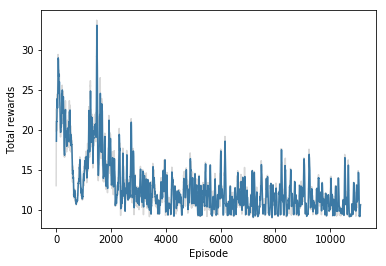

In [31]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Average losses')

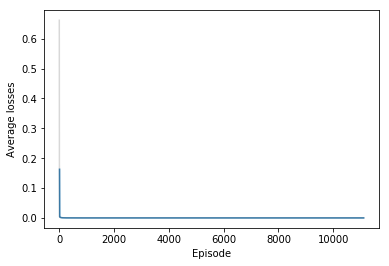

In [32]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [184]:
import gym

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model-seq.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    initial_state = sess.run(model.initial_state) # Qs or current batch or states[:-1]
    state = env.reset()
    total_reward = 0
    while True:
        env.render()
        action_logits, initial_state = sess.run([model.actions_logits, model.final_state],
                                                feed_dict = {model.states: state.reshape([1, -1]), 
                                                             model.initial_state: initial_state})
        action = np.argmax(action_logits)
        state, reward, done, _ = env.step(action)
        total_reward += reward
        if done:
            break
print('total_reward:{}'.format(total_reward))
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward:120.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.